In [1]:
# import necessary packages
from netCDF4 import Dataset
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from tabulate import tabulate
import matplotlib.animation as animation
from scipy.stats import norm
# from pyextremes import get_extremes
# from pyextremes.plotting import plot_extremes
import pyextremes as pe

## Plots

In [2]:
model_root = Path(r"P:\11207365-eoatsee\Sofie\Data\Saved_models")

def load_output(filename):
    output = np.load(filename, allow_pickle=True)
    output = pd.DataFrame(output, columns=["Time", "SL", "Tides", "resid", "ML"])
    output["Time"] = pd.to_datetime(output.Time).round("h")
    output.set_index("Time", inplace=True)
    return output

# testing period: 2015-04-01  -  2018-09-07
vlis = load_output(model_root / "Vlissingen/output_full.npy")
schev = load_output(model_root / "Scheveningen/output_full.npy")
eur = load_output(model_root / "Europlatform/output_full.npy")

In [3]:
dcsm_root = Path(r"P:\11207365-eoatsee\Sofie\Data\vanStendert")

def load_dcsm(filename):
    data = pd.read_csv(filename)
    data["time"] = pd.to_datetime(data.time)
    data.set_index("time", inplace=True)
    return data

dcsm_schev = load_dcsm(dcsm_root / "2D_100m_2013-2017_waterlevel_SCHEVNGN.csv")
dcsm_vlis = load_dcsm(dcsm_root / "2D_100m_2013-2017_waterlevel_VLISSGN.csv")
dcsm_eur = load_dcsm(dcsm_root / "2D_100m_2013-2017_waterlevel_EURPFM.csv")

In [4]:
# filter out all outliers
def filter_new(output, ytrue, tides, times, iterations):
    y = output
    t = times
    yt = ytrue
    ti = tides
    for i in range(iterations):
        diff_output = np.concatenate([np.array([0]), np.diff(y)])
        std = np.std(np.diff(y))
        y = y[abs(diff_output) < np.mean(np.diff(y)) + 4*std]
        yt = yt[abs(diff_output) < np.mean(np.diff(y)) + 4*std]
        t = t[abs(diff_output) < np.mean(np.diff(y)) + 4*std]
        ti = ti[abs(diff_output) < np.mean(np.diff(y)) + 4*std]
    return y, yt, ti, t
        
ypred_vlis, ytrue_vlis, tidesy_vlis, t_vlis = filter_new(vlis.ML, vlis.resid, vlis.Tides, vlis.index, 3)
ypred_schev, ytrue_schev, tidesy_schev, t_schev = filter_new(schev.ML, schev.resid, schev.Tides, schev.index, 3)
ypred_eur, ytrue_eur, tidesy_eur, t_eur = filter_new(eur.ML, eur.resid, eur.Tides, eur.index, 3)

In [5]:
dcsm_vlis = dcsm_vlis.loc[t_vlis[t_vlis <= dcsm_vlis.index[-1]].round("h")]
dcsm_schev = dcsm_schev.loc[t_schev[t_schev <= dcsm_schev.index[-1]].round("h")]
dcsm_eur = dcsm_eur.loc[t_eur[t_eur <= dcsm_eur.index[-1]].round("h")]

dcsm_vlis["tides"] = tidesy_vlis.loc[dcsm_vlis.index]
dcsm_vlis["TG"] = ytrue_vlis.loc[dcsm_vlis.index]
dcsm_vlis["resid"] = dcsm_vlis.waterlevel - dcsm_vlis.tides

dcsm_schev["tides"] = tidesy_schev.loc[dcsm_schev.index]
dcsm_schev["TG"] = ytrue_schev.loc[dcsm_schev.index]
dcsm_schev["resid"] = dcsm_schev.waterlevel - dcsm_schev.tides

dcsm_eur["tides"] = tidesy_eur.loc[dcsm_eur.index]
dcsm_eur["TG"] = ytrue_eur.loc[dcsm_eur.index]
dcsm_eur["resid"] = dcsm_eur.waterlevel - dcsm_eur.tides

In [6]:
def plot_full(true, pred, t, title):
    plt.figure(figsize=(15, 4))
    plt.plot(true, label="TG", color="green")
    plt.plot(pred, label="ML", color="blue")
    plt.grid()
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Non-tidal water level [m]", fontsize=14)
    plt.legend(loc=3)
    # plt.title(title)
    plt.ylim(-2, 2.5)
    ticks = np.arange(t[0], t[-1]+timedelta(days=60), dtype='datetime64[2M]')
    plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right")
    plt.fill_between([datetime(2015, 7, 1), datetime(2015, 8, 1)], -2.5, 3, color="grey", alpha=0.5)
    plt.fill_between([datetime(2016, 11, 1), datetime(2016, 12, 1)], -2.5, 3, color="grey", alpha=0.5)
    plt.fill_between([datetime(2017, 9, 1), datetime(2017, 10, 1)], -2.5, 3, color="grey", alpha=0.5)
    plt.fill_between([datetime(2018, 1, 1), datetime(2018, 2, 1)], -2.5, 3, color="grey", alpha=0.5)
    plt.fill_between([datetime(2016, 12, 15), datetime(2017, 1, 15)], -2.5, 3, color="grey", alpha=0.5)
    plt.fill_between([datetime(2015, 11, 15), datetime(2015, 12, 15)], -2.5, 3, color="grey", alpha=0.5)
    plt.text(datetime(2015, 7, 3), -1.5, "(b)", size="large")
    plt.text(datetime(2015, 11, 17), -1.5, "(c)", size="large")
    plt.text(datetime(2016, 11, 3), -1.5, "(d)", size="large")
    plt.text(datetime(2016, 12, 18), -1.5, "(e)", size="large")
    plt.text(datetime(2017, 9, 5), -1.5, "(f)", size="large")
    plt.text(datetime(2018, 1, 4), -1.5, "(g)", size="large")
    plt.show()

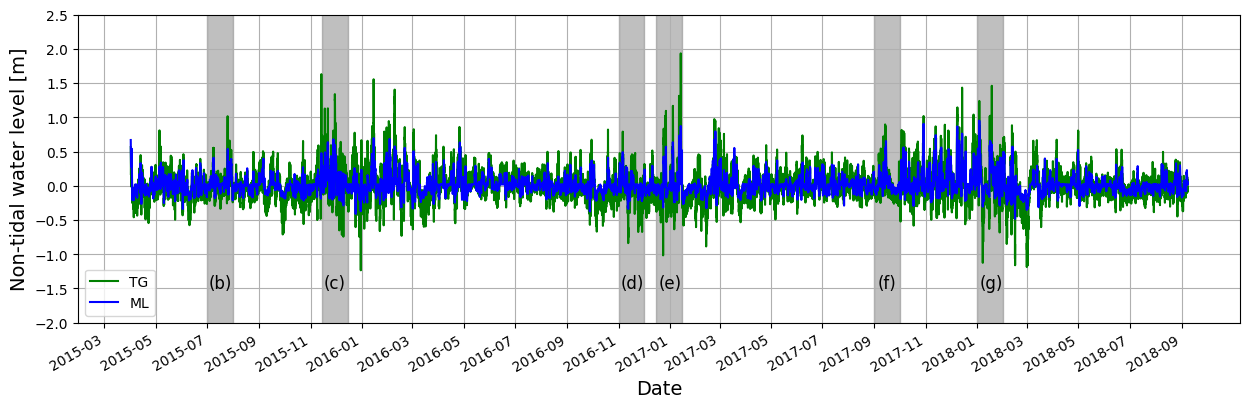

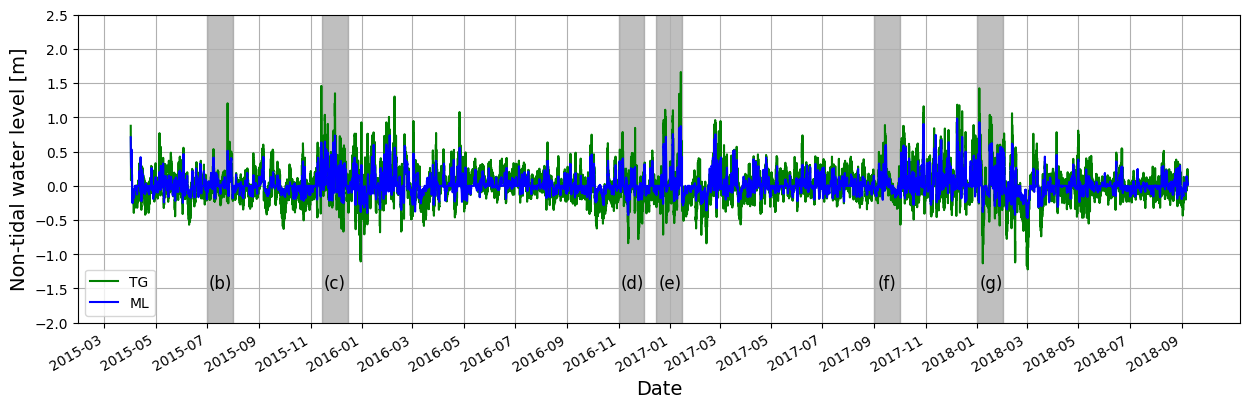

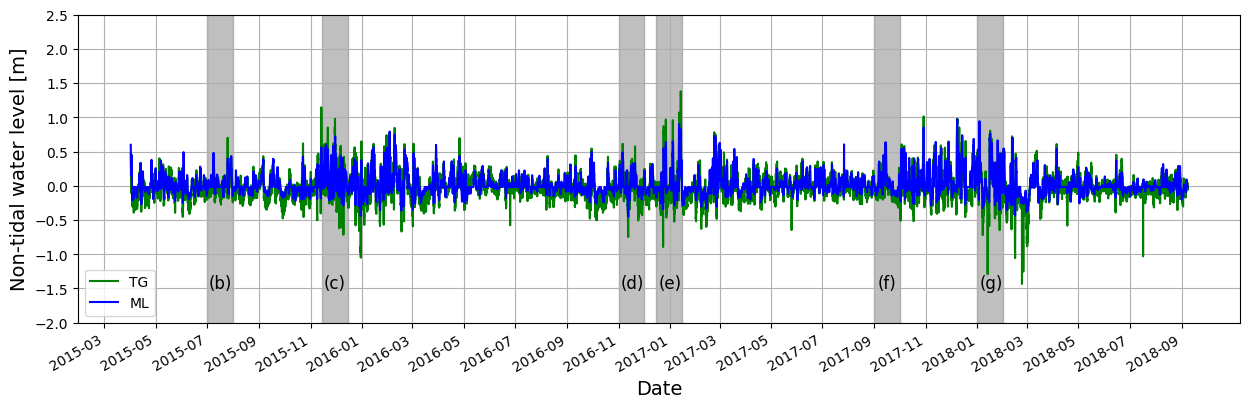

In [7]:
plot_full(ytrue_vlis, ypred_vlis, t_vlis, "Vlissingen")
plot_full(ytrue_schev, ypred_schev, t_schev, "Scheveningen")
plot_full(ytrue_eur, ypred_eur, t_eur, "Europlatform")

In [8]:
def plot_month(true, pred, date_range, title, fontsize=20):
    plt.plot(true, label="TG", color="green")
    plt.plot(pred, label="ML", color="blue")
    plt.grid()
    plt.title(title)
    plt.ylabel("Non-tidal water level [m]", fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc=3)
    plt.ylim(-2, 2.5)
    plt.yticks(ticks=np.arange(-2, 3, 0.5), labels=np.arange(-2, 3, 0.5), fontsize=fontsize)
    newticks = np.arange(date_range[0], date_range[1]+timedelta(days=4), dtype="datetime64[3D]")
    plt.xticks(ticks=newticks, labels=newticks, rotation=30, ha="right", fontsize=fontsize)
    plt.xlim(date_range[0], date_range[1])
    # plt.axvline(datetime(2017, 1, 3), color='k')
    # plt.axvline(datetime(2017, 1, 11), color='k')
    plt.axvline(datetime(2018, 1, 15, 14), color="k")
    plt.fill_between([datetime(2015, 7, 25), datetime(2015, 7, 26)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2016, 11, 20), datetime(2016, 11, 21)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2017, 9, 13), datetime(2017, 9, 15)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2018, 1, 3), datetime(2018, 1, 4, 10)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2018, 1, 18), datetime(2018, 1, 19)], -2, 2.5, color="grey", alpha=0.5)

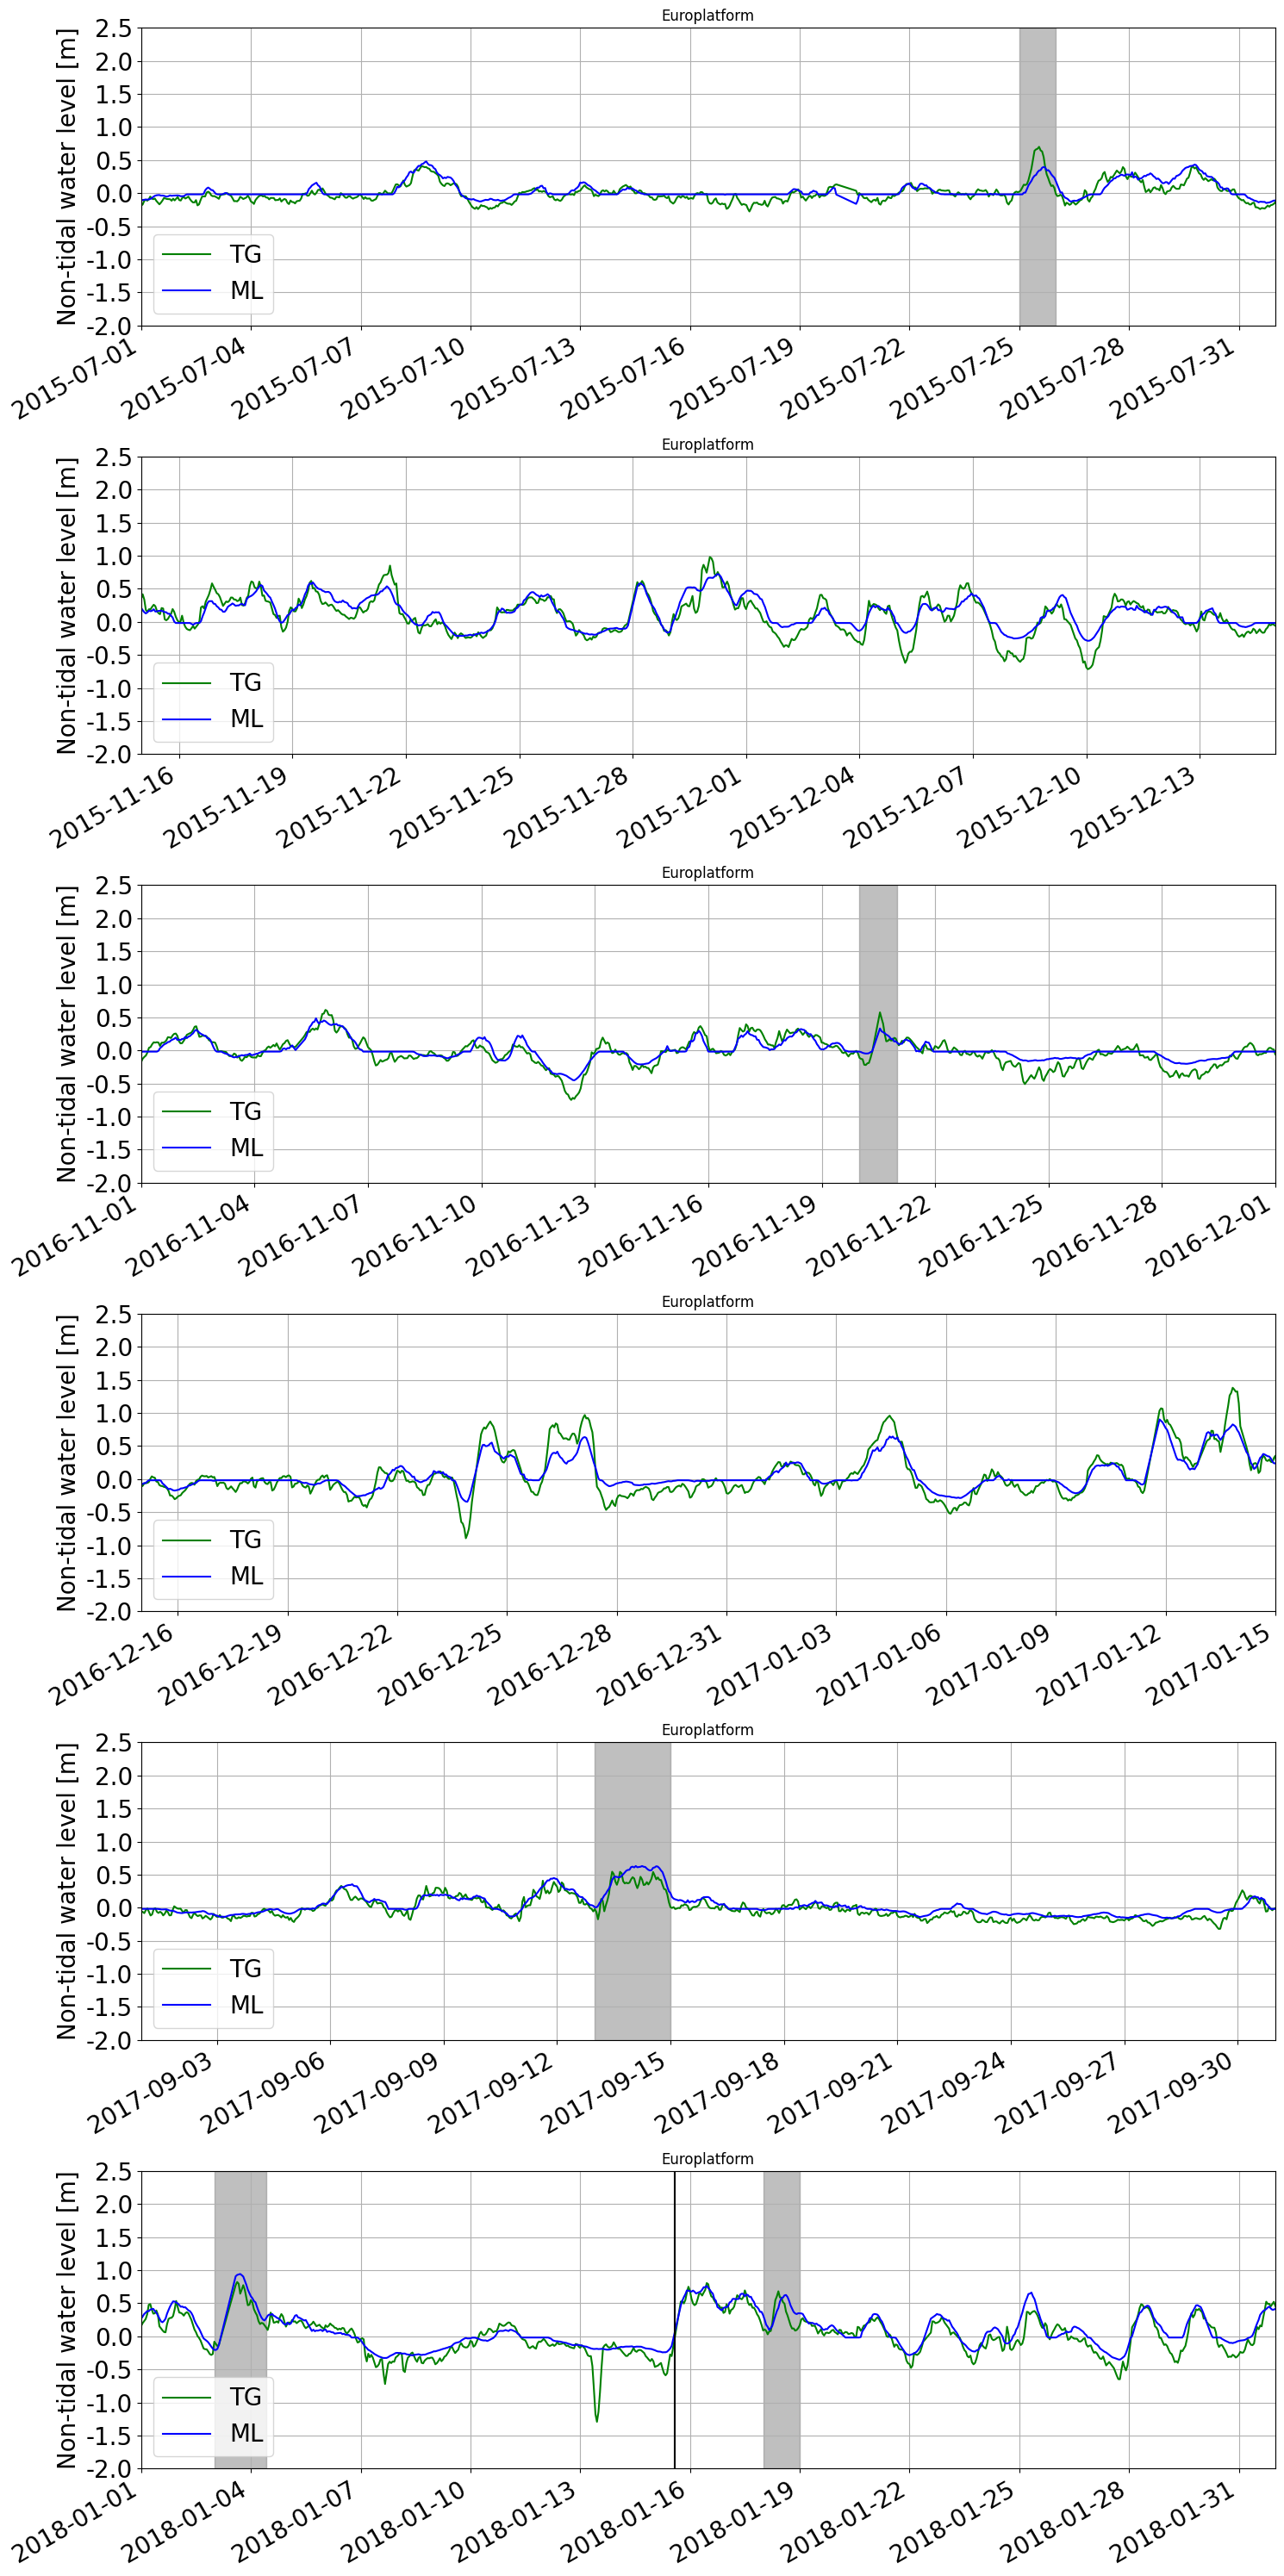

In [9]:
starts = [datetime(2015, 7, 1), datetime(2015, 11, 15), datetime(2016, 11, 1), datetime(2016, 12, 15), datetime(2017, 9, 1), datetime(2018, 1, 1)]
ends = [datetime(2015, 8, 1), datetime(2015, 12, 15), datetime(2016, 12, 1), datetime(2017, 1, 15), datetime(2017, 10, 1), datetime(2018, 2, 1)]

# Vlissingen
# plt.figure(figsize=(15,30))
# for i in range(6):
#     plt.subplot(6,1,i+1)
#     plot_month(ytrue_vlis, ypred_vlis,  (starts[i], ends[i]), "Vlissingen")
# plt.tight_layout()
# plt.show()

# Scheveningen
# plt.figure(figsize=(15,30))
# for i in range(6):
#     plt.subplot(6,1,i+1)
#     plot_month(ytrue_schev, ypred_schev,  (starts[i], ends[i]), "Scheveningen")
# plt.tight_layout()
# plt.show()

# Europlatform
plt.figure(figsize=(15,30))
for i in range(6):
    plt.subplot(6,1,i+1)
    plot_month(ytrue_eur, ypred_eur,  (starts[i], ends[i]), "Europlatform")
plt.tight_layout()
plt.show()

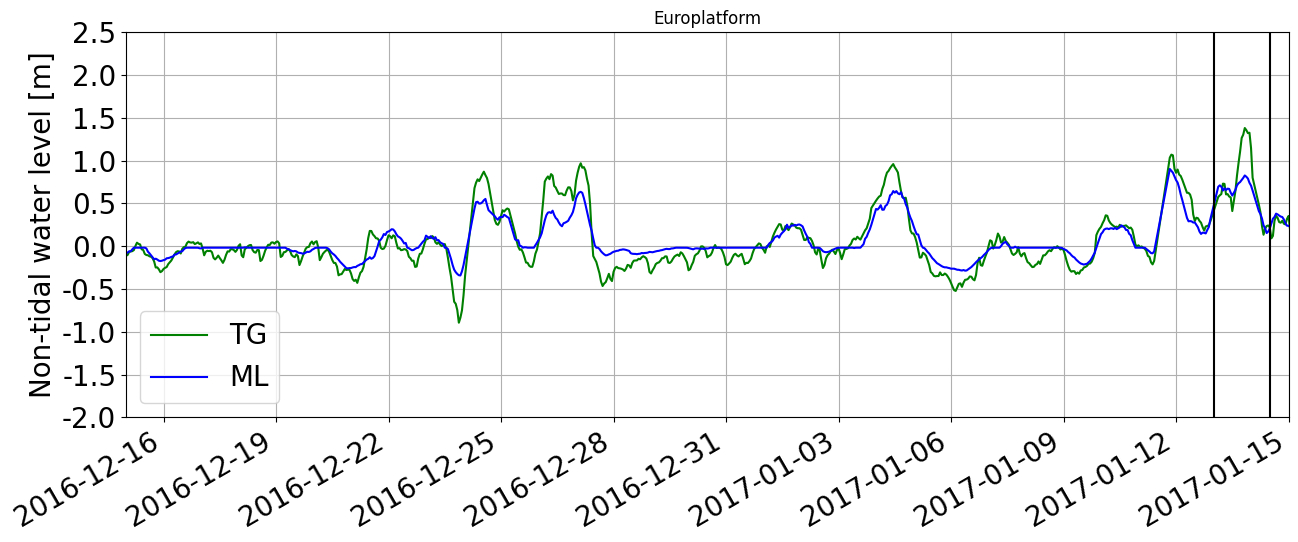

Percentage of constant values within the 95% conficence interval in which they occur for Scheveningen is: 39.466052934407365
Percentage of constant values within the 95% conficence interval in which they occur for Vlissingen is: 28.316420664206642
Percentage of constant values within the 95% conficence interval in which they occur for Europlatform is: 43.825130997636904
Percentage of constant values outside the 95% confidence interval for Scheveningen is: 5.443177638837808
Percentage of constant values outside the 95% confidence interval for Vlissingen is: 3.9306077884265442
Percentage of constant values outside the 95% confidence interval for Europlatform is: 4.467134652201659


In [10]:
# quantify duration of constant
constant = ypred_schev[ypred_schev.index == datetime(2016, 12, 17)].values[0] #-0.001113
constant_vlis = ypred_vlis[ypred_vlis.index == datetime(2016, 12, 22, 5)].values[0]
constant_eur = ypred_eur[ypred_eur.index == datetime(2016, 12, 17, 10)].values[0]

# plt.figure(figsize=(15, 5))
# plot_month(ytrue_schev, ypred_schev,  (datetime(2016, 12, 15), datetime(2017, 1, 15)), "Scheveningen")
# plt.axvline(datetime(2016, 12, 17), color="k")
# plt.show()

# plt.figure(figsize=(15,5))
# plot_month(ytrue_vlis, ypred_vlis, (datetime(2016, 12, 15), datetime(2017, 1, 15)), "Vlissingen")
# plt.axvline(datetime(2016, 12, 22, 5), color="k")
# plt.show()

plt.figure(figsize=(15,5))
plot_month(ytrue_eur, ypred_eur, (datetime(2016, 12, 15), datetime(2017, 1, 15)), "Europlatform")
plt.axvline(datetime(2017, 1, 13), color="k")
plt.axvline(datetime(2017, 1, 14, 12), color="k")
plt.show()

# print("Nr of hours where estimate is constant for Scheveningen:", ypred_schev[ypred_schev == constant].count())
# print("Nr of hours where estimate is constant for Vlissingen:", ypred_vlis[ypred_vlis == constant_vlis].count())
# print("Nr of hours where estimate is constant for Europlatform:", ypred_eur[ypred_eur == constant_eur].count())

# print("Percentage of hours where estimate is constant for Scheveningen:", ypred_schev[ypred_schev == constant].count()/ypred_schev.count())
# print("Percentage of hours where estimate is constant for Vlissingen:", ypred_vlis[ypred_vlis == constant_vlis].count()/ypred_vlis.count())
# print("Percentage of hours where estimate is constant for Europlatform:", ypred_eur[ypred_eur == constant_eur].count()/ypred_eur.count())
# print("Constant for Scheveningen:", np.round(constant, 3))
# print("Constant for Vlissingen:", np.round(constant_vlis, 3))
# print("Constant for Europlatform:", np.round(constant_eur, 3))

# print("Range Scheveningen:", ytrue_schev[ypred_schev == constant].min(), ytrue_schev[ypred_schev == constant].max())
# print("Range Vlissingen:", ytrue_vlis[ypred_vlis == constant_vlis].min(), ytrue_vlis[ypred_vlis == constant_vlis].max())
# print("Range Europlatform:", ytrue_eur[ypred_eur == constant_eur].min(), ytrue_eur[ypred_eur == constant_eur].max())

# print("Mean/std Schev:", ytrue_schev[ypred_schev == constant].mean(), ytrue_schev[ypred_schev == constant].std())
# print("Mean/std Vlis:", ytrue_vlis[ypred_vlis == constant_vlis].mean(), ytrue_vlis[ypred_vlis == constant_vlis].std())
# print("Mean/std Eur:", ytrue_eur[ypred_eur == constant_eur].mean(), ytrue_eur[ypred_eur == constant_eur].std())

# print("95% between", ytrue_schev[ypred_schev == constant].mean()-2*ytrue_schev[ypred_schev == constant].std(), "to", ytrue_schev[ypred_schev == constant].mean()+2*ytrue_schev[ypred_schev == constant].std())
# print("95%", ytrue_vlis[ypred_vlis == constant_vlis].mean()-2*ytrue_vlis[ypred_vlis == constant_vlis].std(), "to", ytrue_vlis[ypred_vlis == constant_vlis].mean()+2*ytrue_vlis[ypred_vlis == constant_vlis].std())
# print("95%", ytrue_eur[ypred_eur == constant_eur].mean()-2*ytrue_eur[ypred_eur == constant_eur].std(), "to", ytrue_eur[ypred_eur == constant_eur].mean()+2*ytrue_eur[ypred_eur == constant_eur].std())

yn = ytrue_schev[ypred_schev != constant]
yy = ytrue_schev[ypred_schev == constant]
countyn = yn[(yn < yy.mean()+2*yy.std()) & (yn > yy.mean()-2*yy.std())].count()
countyy = yy[(yy < yy.mean()+2*yy.std()) & (yy > yy.mean()-2*yy.std())].count()

yn_vlis = ytrue_vlis[ypred_vlis != constant_vlis]
yy_vlis = ytrue_vlis[ypred_vlis == constant_vlis]
countyn_vlis = yn_vlis[(yn_vlis < yy_vlis.mean()+2*yy_vlis.std()) & (yn_vlis > yy_vlis.mean()-2*yy_vlis.std())].count()
countyy_vlis = yy_vlis[(yy_vlis < yy_vlis.mean()+2*yy_vlis.std()) & (yy_vlis > yy_vlis.mean()-2*yy_vlis.std())].count()

yn_eur = ytrue_eur[ypred_eur != constant_eur]
yy_eur = ytrue_eur[ypred_eur == constant_eur]
countyn_eur = yn_eur[(yn_eur < yy_eur.mean()+2*yy_eur.std()) & (yn_eur > yn_eur.mean()-2*yy_eur.std())].count()
countyy_eur = yy_eur[(yy_eur < yy_eur.mean()+2*yy_eur.std()) & (yy_eur > yy_eur.mean()-2*yy_eur.std())].count()

countxn = yn[(yn > yy.mean()+2*yy.std()) | (yn < yy.mean()-2*yy.std())].count()
countxy = yy[(yy > yy.mean()+2*yy.std()) | (yy < yy.mean()-2*yy.std())].count()

countxn_vlis = yn_vlis[(yn_vlis > yy_vlis.mean()+2*yy_vlis.std()) | (yn_vlis < yy_vlis.mean()-2*yy_vlis.std())].count()
countxy_vlis = yy_vlis[(yy_vlis > yy_vlis.mean()+2*yy_vlis.std()) | (yy_vlis < yy_vlis.mean()-2*yy_vlis.std())].count()

countxn_eur = yn_eur[(yn_eur > yy_eur.mean()+2*yy_eur.std()) | (yn_eur < yy_eur.mean()-2*yy_eur.std())].count()
countxy_eur = yy_eur[(yy_eur > yy_eur.mean()+2*yy_eur.std()) | (yy_eur < yy_eur.mean()-2*yy_eur.std())].count()

print("Percentage of constant values within the 95% conficence interval in which they occur for Scheveningen is:", countyy / (countyy + countyn)*100)
print("Percentage of constant values within the 95% conficence interval in which they occur for Vlissingen is:", countyy_vlis / (countyy_vlis + countyn_vlis)*100)
print("Percentage of constant values within the 95% conficence interval in which they occur for Europlatform is:", countyy_eur / (countyy_eur + countyn_eur)*100)
print("Percentage of constant values outside the 95% confidence interval for Scheveningen is:", countxy/(countxy+countxn)*100)
print("Percentage of constant values outside the 95% confidence interval for Vlissingen is:", countxy_vlis/(countxy_vlis+countxn_vlis)*100)
print("Percentage of constant values outside the 95% confidence interval for Europlatform is:", countxy_eur/(countxy_eur+countxn_eur)*100)

In [11]:
maxytrue = ytrue_eur
maxypred = ypred_eur
mindate = datetime(2017, 1, 13)
maxdate = datetime(2017, 1, 14, 12)
# datetime(2018, 1, 3), datetime(2018, 1, 4, 10)
truemax = maxytrue[(maxytrue.index > mindate) & (maxytrue.index < maxdate)].max()
predmax = maxypred[(maxypred.index > mindate) & (maxypred.index < maxdate)].max()

error = truemax - predmax

print("Error:", error)
maxytrue[(maxytrue.index > mindate) & (maxytrue.index < maxdate)].index[maxytrue[(maxytrue.index > mindate) & (maxytrue.index < maxdate)].argmax()]

Error: 0.5543928096127995


Timestamp('2017-01-13 20:00:00')

In [13]:
maxytrue = ytrue_vlis
maxypred = ypred_vlis

# Storm 1
truemax1 = maxytrue[(maxytrue.index > datetime(2015, 7, 25)) & (maxytrue.index < datetime(2015, 7, 26))].max()
predmax1 = maxypred[(maxypred.index > datetime(2015, 7, 25)) & (maxypred.index < datetime(2015, 7, 26))].max()
error1 = truemax1 - predmax1

# Storm 2
truemax2 = maxytrue[(maxytrue.index > datetime(2016, 11, 20)) & (maxytrue.index < datetime(2016, 11, 21))].max()
predmax2 = maxypred[(maxypred.index > datetime(2016, 11, 20)) & (maxypred.index < datetime(2016, 11, 21))].max()
error2 = truemax2 - predmax2

# Storm 3
truemax3 = maxytrue[(maxytrue.index > datetime(2017, 9, 13)) & (maxytrue.index < datetime(2017, 9, 15))].max()
predmax3 = maxypred[(maxypred.index > datetime(2017, 9, 13)) & (maxypred.index < datetime(2017, 9, 15))].max()
error3 = truemax3 - predmax3

# Storm 4
truemax4 = maxytrue[(maxytrue.index > datetime(2018, 1, 3)) & (maxytrue.index < datetime(2018, 1, 4, 10))].max()
predmax4 = maxypred[(maxypred.index > datetime(2018, 1, 3)) & (maxypred.index < datetime(2018, 1, 4, 10))].max()
error4 = truemax4 - predmax4


# Storm 5
truemax5 = maxytrue[(maxytrue.index > datetime(2018, 1, 18)) & (maxytrue.index < datetime(2018, 1, 19))].max()
predmax5 = maxypred[(maxypred.index > datetime(2018, 1, 18)) & (maxypred.index < datetime(2018, 1, 19))].max()
error5 = truemax5 - predmax5

# Print them
print("South", error1)
print("South", error2)
print("North", error3)
print("North", error4)
print("North", error5)

print("Mean South:", (error1+error2)/2)
print("Mean North:", (error3+error4+error5)/3)

0.693 - 0.477

South 0.4771477557855508
South 0.4600833915200528
North 0.2431152690929932
North 0.2870954019821752
North 0.8623356192595235
Mean South: 0.4686155736528018
Mean North: 0.46418209677823064


0.21599999999999997

## Overall performance

In [10]:
# Performance model
ypred_schev, ytrue_schev, tidesy_schev, t_schev

yt_vlis = ytrue_vlis.values + tidesy_vlis.values #[np.where(ytrue_vlis.notnull())]
yp_vlis = ypred_vlis.values + tidesy_vlis.values #[np.where(ytrue_vlis.notnull())]
# ti_vlis = tidesy_vlis.values

yt_schev = ytrue_schev.values[np.where(ytrue_schev.notnull())] + tidesy_schev.values[np.where(ytrue_schev.notnull())]
yp_schev = ypred_schev.values[np.where(ytrue_schev.notnull())] + tidesy_schev.values[np.where(ytrue_schev.notnull())]
# ti_schev = tidesy_schev.values[np.where(ytrue_schev.notnull())]

yt_eur = ytrue_eur.values[np.where(ytrue_eur.notnull())] + tidesy_eur.values[np.where(ytrue_eur.notnull())]
yp_eur = ypred_eur.values[np.where(ytrue_eur.notnull())] + tidesy_eur.values[np.where(ytrue_eur.notnull())]
# ti_eur = tidesy_eur.values[np.where(ytrue_eur.notnull())]

def snr(true, pred):
    r = true - pred
    s = np.var(true)
    n = np.var(r)
    snr = s/n
    return snr

# For Vlissingen
mse_vlis = mean_squared_error(yt_vlis, yp_vlis)
snr_vlis = snr(yt_vlis, yp_vlis)
mae_vlis = mean_absolute_error(yt_vlis, yp_vlis)
std_vlis = np.std(yt_vlis - yp_vlis)

# For Scheveningen
mse_schev = mean_squared_error(yt_schev, yp_schev)
snr_schev = snr(yt_schev, yp_schev)
mae_schev = mean_absolute_error(yt_schev, yp_schev)
std_schev = np.std(yt_schev - yp_schev)

# For Europlatform
mse_eur = mean_squared_error(yt_eur, yp_eur)
snr_eur = snr(yt_eur, yp_eur)
mae_eur = mean_absolute_error(yt_eur, yp_eur)
std_eur = np.std(yt_eur - yp_eur)

mse = [mse_schev, mse_vlis, mse_eur]
snre = [snr_schev, snr_vlis, snr_eur]
# pcc = [pcc_schev[0], pcc_vlis[0], pcc_eur[0]]
# pcc_p = [pcc_schev[1], pcc_vlis[1], pcc_eur[1]]
# print("p value of PCC is:", pcc_p)
mae = [mae_schev, mae_vlis, mae_eur]
stde = [std_schev, std_vlis, std_eur]

# Sample datasets and metric values
datasets = ["Scheveningen", "Vlissingen", "Europlatform"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="presta") # "presta" for inline table representation

# Print the table
print(table)

Dataset             MSE       SNR        MAE    Standard error
------------  ---------  --------  ---------  ----------------
Scheveningen  0.0181192   22.7492  0.100796           0.134471
Vlissingen    0.0182041  101.04    0.0988549          0.134914
Europlatform  0.0109053   37.4036  0.0778575          0.099554


In [11]:
# Performance DCSM

dcsm_true_vlis = dcsm_vlis.TG.values + dcsm_vlis.tides.values#[np.where(dcsm_vlis.TG.notnull())]
dcsm_pred_vlis = dcsm_vlis.resid.values + dcsm_vlis.tides.values#[np.where(dcsm_vlis.TG.notnull())]

dcsm_true_schev = dcsm_schev.TG.values[np.where(dcsm_schev.TG.notnull())] + dcsm_schev.tides.values[np.where(dcsm_schev.TG.notnull())]
dcsm_pred_schev = dcsm_schev.resid.values[np.where(dcsm_schev.TG.notnull())] + dcsm_schev.tides.values[np.where(dcsm_schev.TG.notnull())]

dcsm_true_eur = dcsm_eur.TG.values[np.where(dcsm_eur.TG.notnull())] + dcsm_eur.tides.values[np.where(dcsm_eur.TG.notnull())]
dcsm_pred_eur = dcsm_eur.resid.values[np.where(dcsm_eur.TG.notnull())] + dcsm_eur.tides.values[np.where(dcsm_eur.TG.notnull())]

# For Vlissingen
mse_vlis = mean_squared_error(dcsm_true_vlis, dcsm_pred_vlis)
snr_vlis = snr(dcsm_true_vlis, dcsm_pred_vlis)
mae_vlis = mean_absolute_error(dcsm_true_vlis, dcsm_pred_vlis)
std_vlis = np.std(dcsm_true_vlis - dcsm_pred_vlis)

# For Scheveningen
mse_schev = mean_squared_error(dcsm_true_schev, dcsm_pred_schev)
snr_schev = snr(dcsm_true_schev, dcsm_pred_schev)
mae_schev = mean_absolute_error(dcsm_true_schev, dcsm_pred_schev)
std_schev = np.std(dcsm_true_schev - dcsm_pred_schev)

# For Europlatform
mse_eur = mean_squared_error(dcsm_true_eur, dcsm_pred_eur)
snr_eur = snr(dcsm_true_eur, dcsm_pred_eur)
mae_eur = mean_absolute_error(dcsm_true_eur, dcsm_pred_eur)
std_eur = np.std(dcsm_true_eur - dcsm_pred_eur)

mse = [mse_schev, mse_vlis, mse_eur]
snre = [snr_schev, snr_vlis, snr_eur]
# pcc = [pcc_schev[0], pcc_vlis[0], pcc_eur[0]]
# pcc_p = [pcc_schev[1], pcc_vlis[1], pcc_eur[1]]
# print("p value of PCC is:", pcc_p)
mae = [mae_schev, mae_vlis, mae_eur]
stde = [std_schev, std_vlis, std_eur]

# Sample datasets and metric values
datasets = ["Scheveningen", "Vlissingen", "Europlatform"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="presta")

# Print the table
print(table)

Dataset              MSE      SNR        MAE    Standard error
------------  ----------  -------  ---------  ----------------
Scheveningen  0.00385342  106.096  0.048617          0.0620001
Vlissingen    0.00467086  398.25   0.0537296         0.0677774
Europlatform  0.00388451  135.63   0.0488372         0.0520837


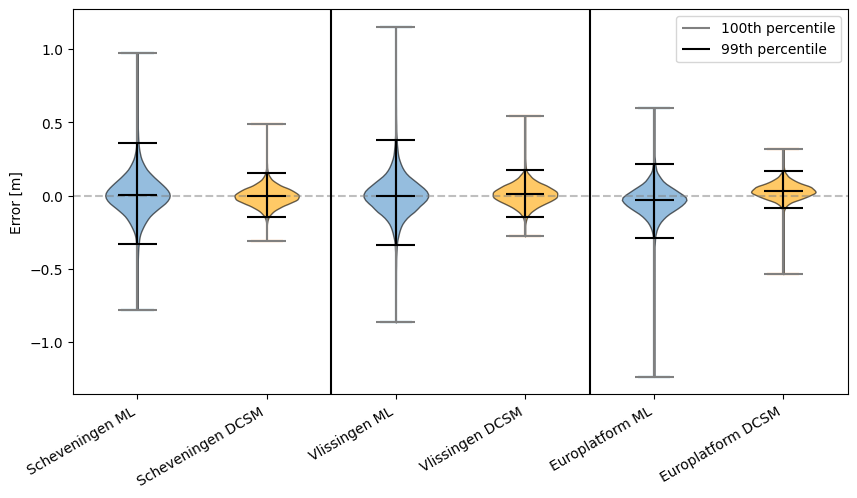

In [12]:
e_schev = yt_schev - yp_schev
e_schev_dcsm = dcsm_true_schev - dcsm_pred_schev

e_vlis = yt_vlis - yp_vlis
e_vlis_dcsm = dcsm_true_vlis - dcsm_pred_vlis

e_eur = yt_eur - yp_eur
e_eur_dcsm = dcsm_true_eur - dcsm_pred_eur

pos = [1, 2, 3, 4, 5, 6]
range_q = [0,1]
data = [np.array(e_schev).astype("float32"), np.array(e_schev_dcsm).astype("float32"), np.array(e_vlis).astype("float32"),
        np.array(e_vlis_dcsm).astype("float32"), np.array(e_eur).astype("float32"), np.array(e_eur_dcsm).astype("float32")]

plt.figure(figsize=(10, 5))
plt.axhline(0, linestyle="--", alpha=0.5, color="grey")
vp1 = plt.violinplot([data[0], data[2], data[4]], [1, 3, 5], showmedians=True, showextrema=True, quantiles=[range_q, range_q, range_q])
vp2 = plt.violinplot([data[1], data[3], data[5]], [2, 4, 6], showmedians=True, showextrema=True, quantiles=[range_q, range_q, range_q])
for pc in vp1['bodies']:
    pc.set_facecolor('#4F92C9')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
for pc in vp2['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks(pos, ["Scheveningen ML", "Scheveningen DCSM", "Vlissingen ML", "Vlissingen DCSM", "Europlatform ML", "Europlatform DCSM"], rotation=30, ha="right")
for i in range(6):
    quantiles = np.percentile(data[i], [0, 50, 100])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="grey")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="grey")
    if i < 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="grey")
    elif i == 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="grey", label="100th percentile")
for i in range(6):
    quantiles = np.percentile(data[i], [1, 50, 99])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="k")
    plt.hlines(quantiles[1], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    if i < 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    elif i == 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k", label="99th percentile")
plt.ylabel("Error [m]")
plt.axvline(2.5, color="k")
plt.axvline(4.5, color="k")
plt.xlim(0.5, 6.5)
# plt.ylim(-1, 1.25)
plt.legend()
plt.show()

Text(0.5, 0, 'Observed water level [m]')

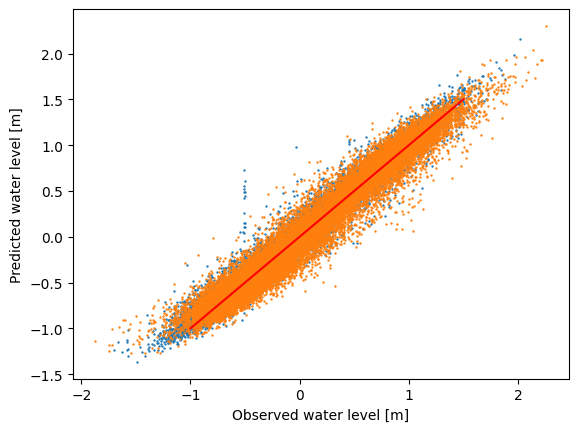

In [13]:
# yt_schev
# yp_schev

plt.scatter(yt_eur, yp_eur, s=0.5)
plt.scatter(yt_schev, yp_schev, s=0.5)
plt.plot([-1, 1.5],[-1, 1.5],color="r")
plt.ylabel("Predicted water level [m]")
plt.xlabel("Observed water level [m]")

## K-fold cross validation plots

In [14]:
schev4 = load_output(model_root / "Scheveningen/output1.npy")
schev2 = load_output(model_root / "Scheveningen/output2.npy")
schev3 = load_output(model_root / "Scheveningen/output3.npy")
schev1 = load_output(model_root / "Scheveningen/output4.npy")

In [15]:
ypred_1, ytrue_1, tidesy_1, t_1 = filter_new(schev1.ML, schev1.resid, schev1.Tides, schev1.index, 7)
ypred_2, ytrue_2, tidesy_2, t_2 = filter_new(schev2.ML, schev2.resid, schev2.Tides, schev2.index, 7)
ypred_3, ytrue_3, tidesy_3, t_3 = filter_new(schev3.ML, schev3.resid, schev3.Tides, schev3.index, 7)
ypred_4, ytrue_4, tidesy_4, t_4 = filter_new(schev4.ML, schev4.resid, schev4.Tides, schev4.index, 7)

In [16]:
def plot_k(true, pred, t, title):
    plt.figure(figsize=(15, 4))
    plt.plot(true, label="TG", color="green")
    plt.plot(pred, label="ML", color="blue")
    plt.grid()
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Non-tidal water level [m]", fontsize=14)
    plt.legend(loc=3)
    plt.ylim(-2, 2.5)
    ticks = np.arange(t[0], t[-1]+timedelta(days=60), dtype='datetime64[2M]')
    plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right")
    # newticks = np.arange(date_range[0], date_range[1], dtype="datetime64[2D]")
    # plt.xticks(ticks=newticks, labels=newticks, rotation=30, ha="right")
    # plt.xlim(date_range[0], date_range[1])
    plt.title(title)

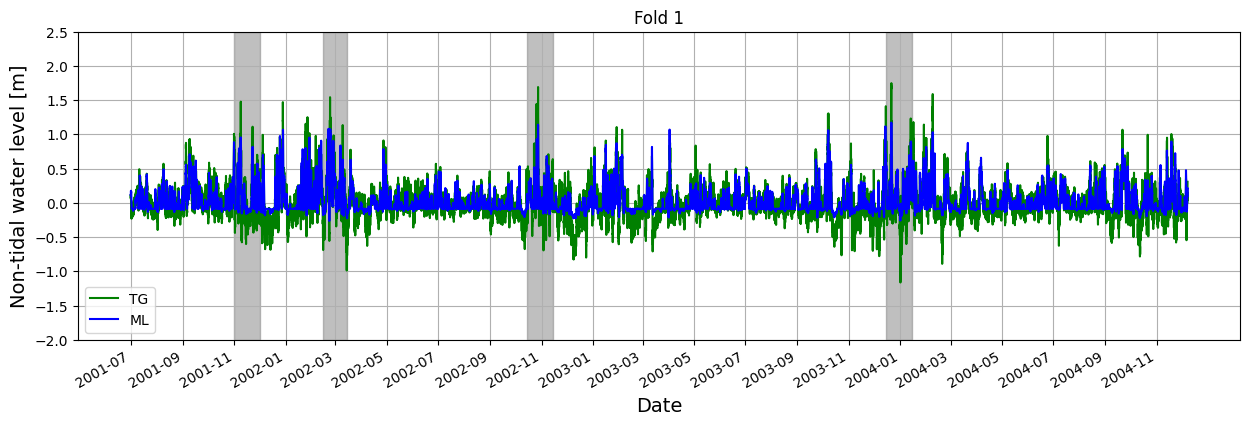

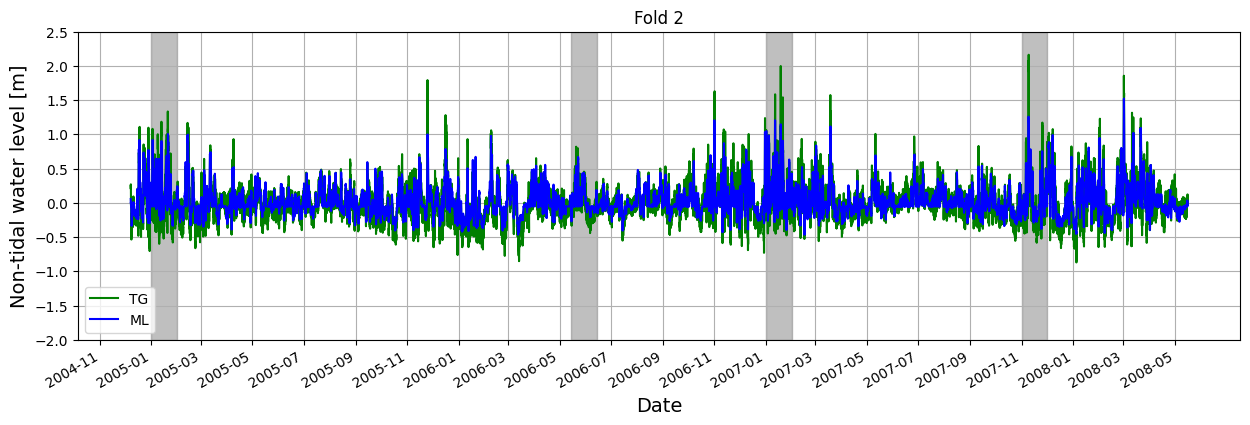

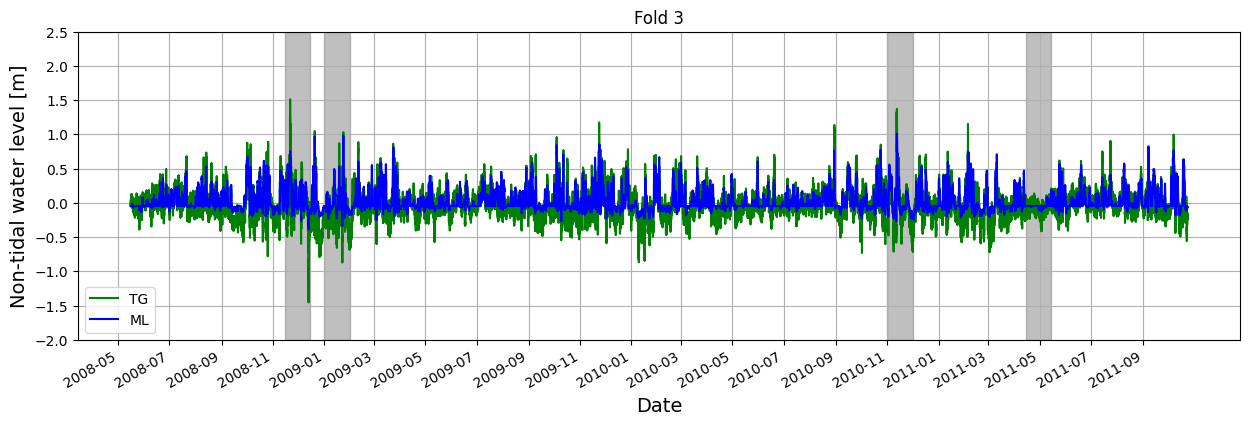

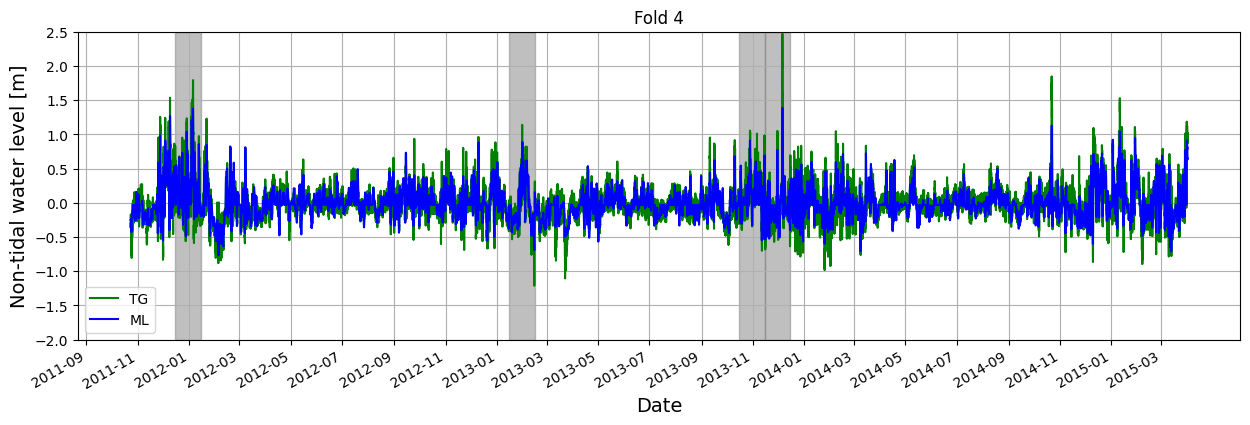

In [17]:
plot_k(ytrue_1, ypred_1, t_1, "Fold 1")
plt.fill_between([datetime(2002, 2, 15), datetime(2002, 3, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2002, 10, 15), datetime(2002, 11, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2003, 12, 15), datetime(2004, 1, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2001, 11, 1), datetime(2001, 12, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.show()
plot_k(ytrue_2, ypred_2, t_2, "Fold 2")
plt.fill_between([datetime(2007, 1, 1), datetime(2007, 2, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2006, 5, 15), datetime(2006, 6, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2007, 11, 1), datetime(2007, 12, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2005, 1, 1), datetime(2005, 2, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.show()
plot_k(ytrue_3, ypred_3, t_3, "Fold 3")
plt.fill_between([datetime(2008, 11, 15), datetime(2008, 12, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2009, 1, 1), datetime(2009, 2, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2010, 11, 1), datetime(2010, 12, 1)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2011, 4, 15), datetime(2011, 5, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.show()
plot_k(ytrue_4, ypred_4, t_4, "Fold 4")
plt.fill_between([datetime(2013, 10, 15), datetime(2013, 11, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2013, 11, 15), datetime(2013, 12, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2011, 12, 15), datetime(2012, 1, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.fill_between([datetime(2013, 1, 15), datetime(2013, 2, 15)], -2, 2.5, color="grey", alpha=0.5)
plt.show()

In [18]:
def plot_k_month(true, pred, date_range, title, fontsize=20):
    # plt.figure(figsize=(15, 4))
    plt.plot(true, label="TG", color="green")
    plt.plot(pred, label="ML", color="blue")
    plt.grid()
    # plt.xlabel("Time")
    plt.ylabel("Non-tidal water level [m]", fontsize=fontsize)
    plt.legend(fontsize=fontsize, loc=3)
    plt.ylim(-2, 2.5)
    plt.yticks(ticks=np.arange(-2, 3, 0.5), labels=np.arange(-2, 3, 0.5), fontsize=fontsize)
    newticks = np.arange(date_range[0], date_range[1]+timedelta(days=5), dtype="datetime64[3D]")
    plt.xticks(ticks=newticks, labels=newticks, rotation=30, ha="right", fontsize=fontsize)
    plt.xlim(date_range[0], date_range[1])
    plt.title(title)    
    # plt.fill_between([datetime(2002, 2, 26), datetime(2002, 2, 27, 12)], -2, 2.5, color="grey", alpha=0.5)
    # plt.fill_between([datetime(2002, 3, 9), datetime(2002, 3, 10, 6)], -2, 2.5, color="grey", alpha=0.5)
    # plt.fill_between([datetime(2002, 10, 27, 6), datetime(2002, 10, 28, 12)], -2, 2.5, color="grey", alpha=0.5)
    # plt.fill_between([datetime(2007, 1, 18), datetime(2007, 1, 19, 6)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2013, 10, 28), datetime(2013, 10, 29)], -2, 2.5, color="grey", alpha=0.5)
    plt.fill_between([datetime(2013, 12, 5, 12), datetime(2013, 12, 7)], -2, 2.5, color="grey", alpha=0.5)
    # plt.show()

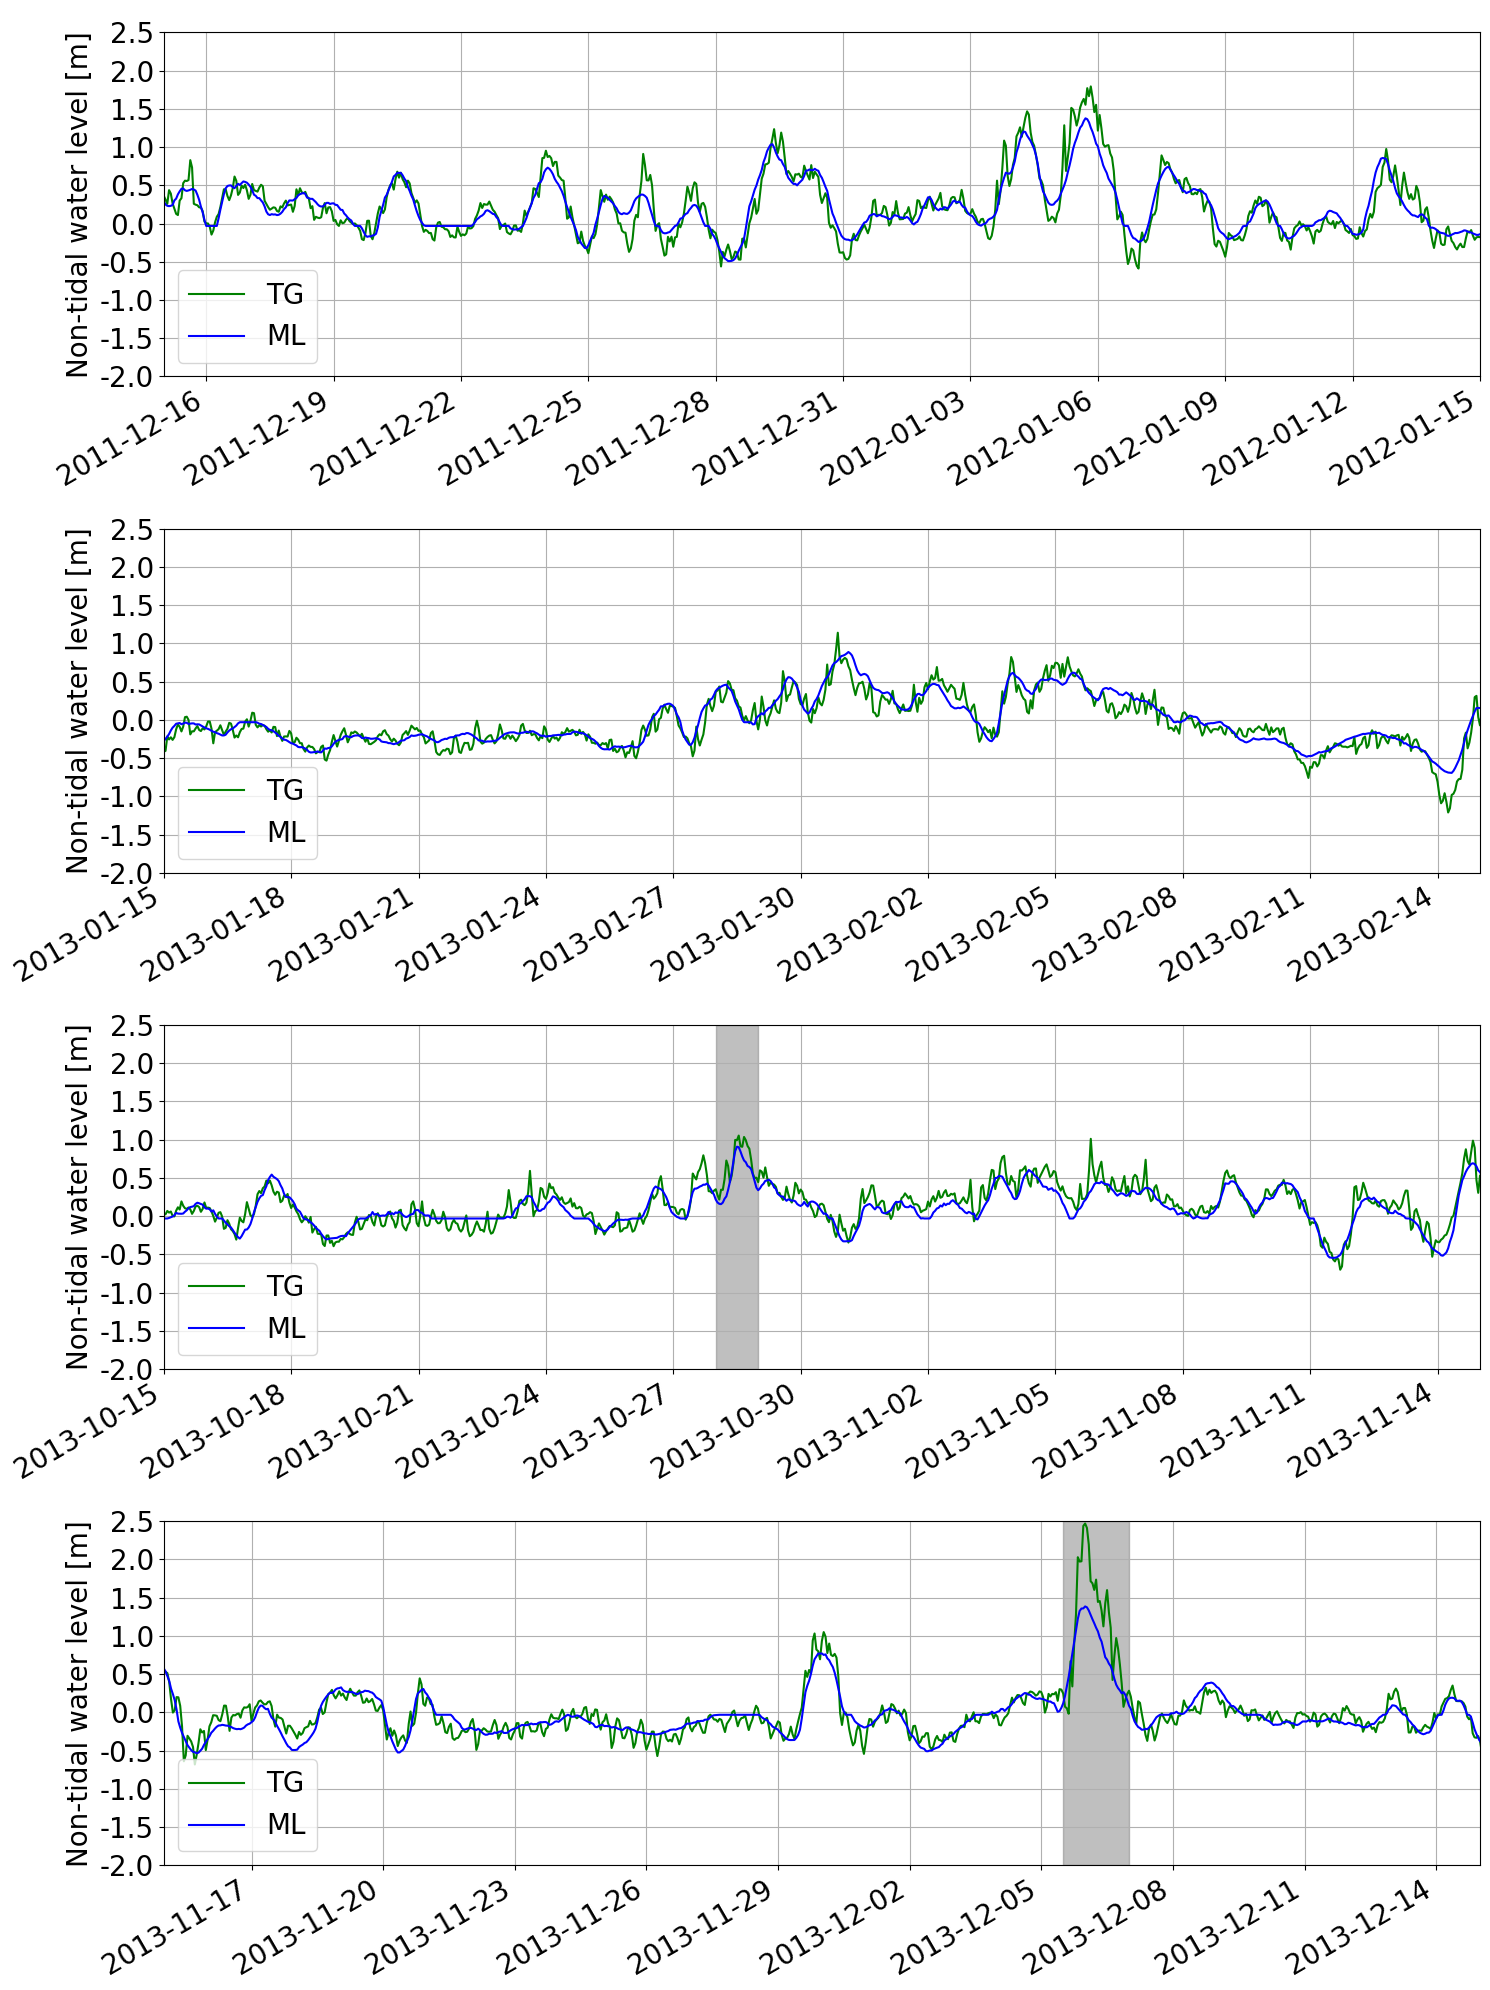

In [19]:
# Validation set 1
# starts = [datetime(2001, 11, 1), datetime(2002, 2, 15), datetime(2002, 10, 15), datetime(2003, 12, 15)]
# ends = [datetime(2001, 12, 1), datetime(2002, 3, 15), datetime(2002, 11, 15), datetime(2004, 1, 15)]

# plt.figure(figsize=(15,20))
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plot_k_month(ytrue_1, ypred_1,  (starts[i], ends[i]), " ")
# plt.tight_layout()
# plt.show()

# Validation set 2
# starts = [datetime(2005, 1, 1), datetime(2006, 5, 15), datetime(2007, 1, 1), datetime(2007, 11, 1)]
# ends = [datetime(2005, 2, 1), datetime(2006, 6, 15), datetime(2007, 2, 1), datetime(2007, 12, 1)]

# plt.figure(figsize=(15,20))
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plot_k_month(ytrue_2, ypred_2,  (starts[i], ends[i]), " ")
# plt.tight_layout()
# plt.show()

# Validation set 3
# starts = [datetime(2008, 11, 15), datetime(2009, 1, 1), datetime(2010, 11, 1), datetime(2011, 4, 15)]
# ends = [datetime(2008, 12, 15), datetime(2009, 2, 1), datetime(2010, 12, 1), datetime(2011, 5, 15)]

# plt.figure(figsize=(15,20))
# for i in range(4):
#     plt.subplot(4,1,i+1)
#     plot_k_month(ytrue_3, ypred_3,  (starts[i], ends[i]), " ")
# plt.tight_layout()
# plt.show()

# Validation set 4
starts = [datetime(2011, 12, 15), datetime(2013, 1, 15), datetime(2013, 10, 15), datetime(2013, 11, 15)]
ends = [datetime(2012, 1, 15), datetime(2013, 2, 15), datetime(2013, 11, 15), datetime(2013, 12, 15)]

plt.figure(figsize=(15,20))
for i in range(4):
    plt.subplot(4,1,i+1)
    plot_k_month(ytrue_4, ypred_4,  (starts[i], ends[i]), " ")
plt.tight_layout()
plt.show()

## K-fold cross validation performance

In [20]:
# Performance model
yt_1 = ytrue_1.values + tidesy_1.values #[np.where(ytrue_vlis.notnull())]
yp_1 = ypred_1.values + tidesy_1.values#[np.where(ytrue_vlis.notnull())]

yt_2 = ytrue_2.values + tidesy_2.values#[np.where(ytrue_schev.notnull())]
yp_2 = ypred_2.values + tidesy_2.values#[np.where(ytrue_schev.notnull())]

yt_3 = ytrue_3.values + tidesy_3.values#[np.where(ytrue_schev.notnull())]
yp_3 = ypred_3.values + tidesy_3.values#[np.where(ytrue_schev.notnull())]

yt_4 = ytrue_4.values + tidesy_4.values#[np.where(ytrue_schev.notnull())]
yp_4 = ypred_4.values + tidesy_4.values#[np.where(ytrue_schev.notnull())]

# For validation set 1
mse_1 = mean_squared_error(yt_1, yp_1)
snr_1 = snr(yt_1, yp_1)
mae_1 = mean_absolute_error(yt_1, yp_1)
std_1 = np.std(yt_1 - yp_1)

# For validation set 2
mse_2 = mean_squared_error(yt_2, yp_2)
snr_2 = snr(yt_2, yp_2)
mae_2 = mean_absolute_error(yt_2, yp_2)
std_2 = np.std(yt_2 - yp_2)

# For validation set 3
mse_3 = mean_squared_error(yt_3, yp_3)
snr_3 = snr(yt_3, yp_3)
mae_3 = mean_absolute_error(yt_3, yp_3)
std_3 = np.std(yt_3 - yp_3)

# For validation set 4
mse_4 = mean_squared_error(yt_4, yp_4)
snr_4 = snr(yt_4, yp_4)
mae_4 = mean_absolute_error(yt_4, yp_4)
std_4 = np.std(yt_4 - yp_4)

mse = [mse_1, mse_2, mse_3, mse_4]
snre = [snr_1, snr_2, snr_3, snr_4]
# pcc = [pcc_1[0], pcc_2[0], pcc_3[0], pcc_4[0]]
# pcc_p = [pcc_1[1], pcc_2[1], pcc_3[1], pcc_4[1]]
# print("p value of PCC is:", pcc_p)
mae = [mae_1, mae_2, mae_3, mae_4]
stde = [std_1, std_2, std_3, std_4]

# Sample datasets and metric values
datasets = ["Validation set 1", "Validaiton set 2", "Validation set 3", "Validation set 4"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="latex") # "presta" for inline table representation

# Print the table
print(table)

\begin{tabular}{lrrrr}
\hline
 Dataset          &       MSE &     SNR &       MAE &   Standard error \\
\hline
 Validation set 1 & 0.018808  & 23.0875 & 0.102061  &         0.136839 \\
 Validaiton set 2 & 0.0162263 & 27.8403 & 0.0967358 &         0.126259 \\
 Validation set 3 & 0.0180354 & 24.9046 & 0.101018  &         0.129169 \\
 Validation set 4 & 0.014503  & 30.1418 & 0.0897687 &         0.119893 \\
\hline
\end{tabular}


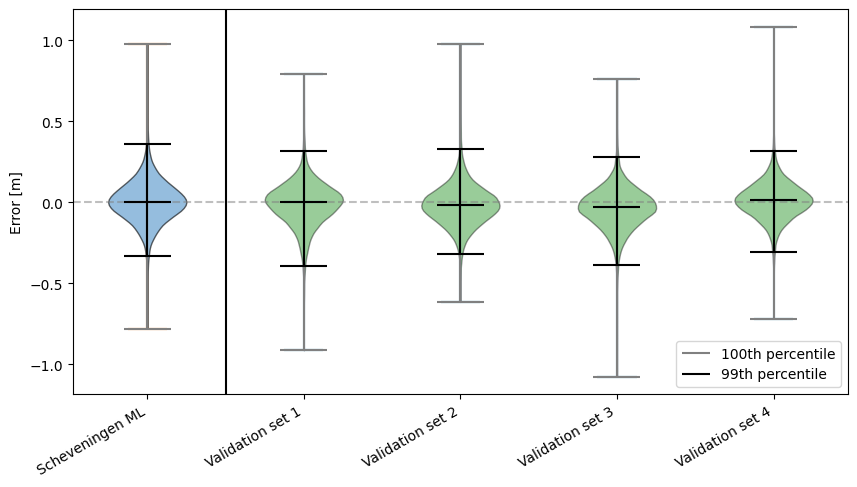

In [21]:
e1 = yt_1 - yp_1
e2 = yt_2 - yp_2
e3 = yt_3 - yp_3
e4 = yt_4 - yp_4
e0 = yt_schev - yp_schev

pos = [1, 2, 3, 4, 5]
range_q = [0,1]
data = [np.array(e0).astype("float32"), np.array(e1).astype("float32"), np.array(e2).astype("float32"),
        np.array(e3).astype("float32"), np.array(e4).astype("float32")]

plt.figure(figsize=(10, 5))
plt.axhline(0, linestyle="--", alpha=0.5, color="grey")
vp1 = plt.violinplot([data[1], data[2], data[3], data[4]], [2, 3, 4, 5], showmedians=True, showextrema=True, quantiles=[range_q, range_q, range_q, range_q])
vp2 = plt.violinplot([data[0]], [1], showmedians=True, showextrema=True, quantiles=[range_q])
for pc in vp1['bodies']:
    pc.set_facecolor('green')
    pc.set_edgecolor('k')
    pc.set_alpha(0.4)
for pc in vp2['bodies']:
    pc.set_facecolor('#4F92C9')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks(pos, ["Scheveningen ML", "Validation set 1", "Validation set 2", "Validation set 3", "Validation set 4"], rotation=30, ha="right")
for i in range(5):
    quantiles = np.percentile(data[i], [0, 50, 100])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="grey")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="grey")
    if i < 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="grey")
    elif i == 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="grey", label="100th percentile")
for i in range(5):
    quantiles = np.percentile(data[i], [1, 50, 99])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="k")
    plt.hlines(quantiles[1], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    if i < 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    elif i == 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k", label="99th percentile")
plt.ylabel("Error [m]")
plt.axvline(1.5, color="k")
plt.legend(loc=4)
plt.show()

In [22]:
print("MSE:", (np.mean(mse)).round(3), "m +-", (np.max(mse) - np.min(mse)).round(3), "m")
print("SNR:", (np.mean(snre)).round(3), "+-", (np.max(snre) - np.min(snre)).round(3))
print("MAE:", (np.mean(mae)).round(3), "m +-", (np.max(mae) - np.min(mae)).round(3), "m")
print("Standard error:", (np.mean(stde)).round(3), "m +-", (np.max(stde) - np.min(stde)).round(3), "m")

MSE: 0.017 m +- 0.004 m
SNR: 26.494 +- 7.054
MAE: 0.097 m +- 0.012 m
Standard error: 0.128 m +- 0.017 m


In [23]:
me1 = np.mean(yt_1 - yp_1)
me2 = np.mean(yt_2 - yp_2)
me3 = np.mean(yt_3 - yp_3)
me4 = np.mean(yt_4 - yp_4)

print("95% set 1:", (me1 - 2*stde[0]).round(3), "to", (me1 + 2*stde[0]).round(3), "m --> range =", (me1 + 2*stde[0]).round(3) - (me1 - 2*stde[0]).round(3))
print("95% set 2:", (me2 - 2*stde[1]).round(3), "to", (me2 + 2*stde[1]).round(3), "m --> range =", (me2 + 2*stde[1]).round(3) - (me2 - 2*stde[1]).round(3))
print("95% set 3:", (me3 - 2*stde[2]).round(3), "to", (me3 + 2*stde[2]).round(3), "m --> range =", (me3 + 2*stde[2]).round(3) - (me3 - 2*stde[2]).round(3))
print("95% set 4:", (me4 - 2*stde[3]).round(3), "to", (me4 + 2*stde[3]).round(3), "m --> range =", (me4 + 2*stde[3]).round(3) - (me4 - 2*stde[3]).round(3))

95% set 1: -0.283 to 0.265 m --> range = 0.548
95% set 2: -0.269 to 0.236 m --> range = 0.505
95% set 3: -0.295 to 0.222 m --> range = 0.517
95% set 4: -0.228 to 0.251 m --> range = 0.479


## Threshold selection

In [24]:
tg_root = Path(r"P:\11207365-eoatsee\Sofie\Data\Tide_gauge_processed")

def load_tg(filename):
    data = pd.read_csv(filename)
    data["datetime"] = pd.to_datetime(data["datetime"])
    data.set_index("datetime", inplace=True)
    return data

tg_vlis = load_tg(tg_root / "vlissingen-vlissgn-nld-rwsHatyan.csv")
tg_schev = load_tg(tg_root / "scheveningen-schevngn-nld-rwsHatyan.csv")
tg_eur = load_tg(tg_root / "euro_platform-eurpfm-nld-rwsHatyan.csv")

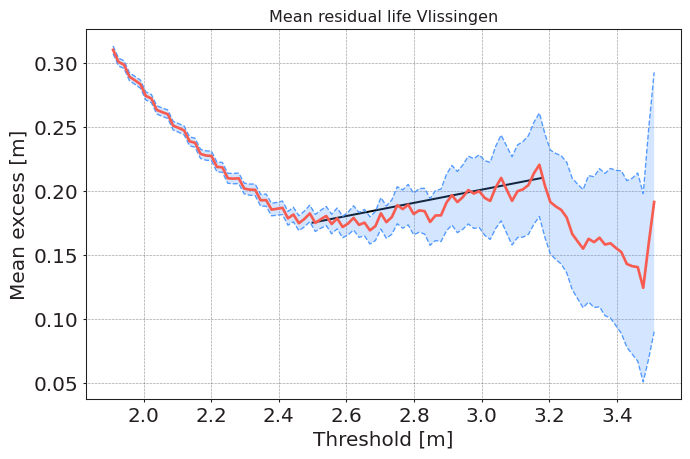

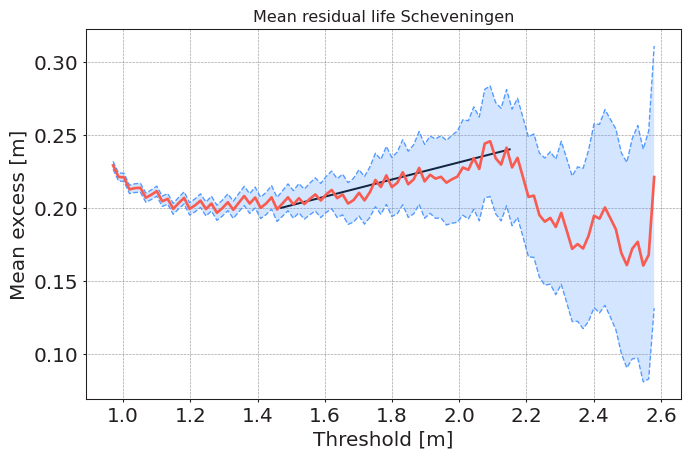

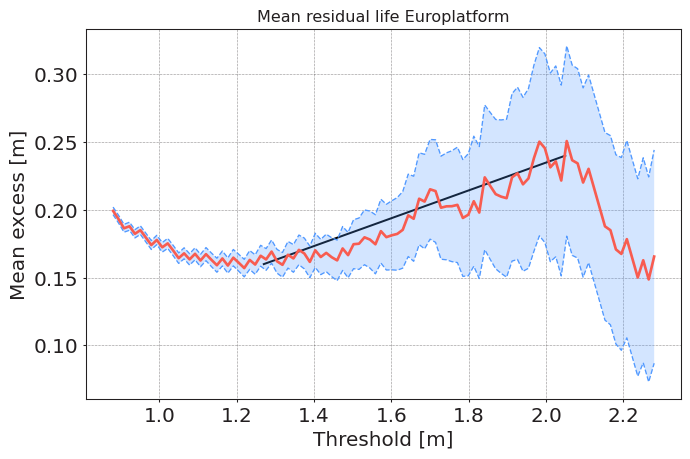

In [25]:
pe.plot_mean_residual_life(tg_vlis.SL.dropna())
plt.plot([2.5, 3.18], [0.175, 0.21], color="k")
plt.title("Mean residual life Vlissingen")
plt.grid()
plt.xlabel("Threshold [m]", fontsize=15)
plt.ylabel("Mean excess [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

pe.plot_mean_residual_life(tg_schev.SL.dropna())
plt.plot([1.47, 2.15], [0.2, 0.24], color="k")
plt.title("Mean residual life Scheveningen")
plt.grid()
plt.xlabel("Threshold [m]", fontsize=15)
plt.ylabel("Mean excess [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

pe.plot_mean_residual_life(tg_eur.SL.dropna())
plt.plot([1.27, 2.05], [0.16, 0.24], color="k")
plt.title("Mean residual life Europlatform")
plt.grid()
plt.xlabel("Threshold [m]", fontsize=15)
plt.ylabel("Mean excess [m]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

calculating stability parameters: 100%|██████████| 100/100 [05:21<00:00,  3.21s/it]
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\4206377240.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\4206377240.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\4206377240.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)


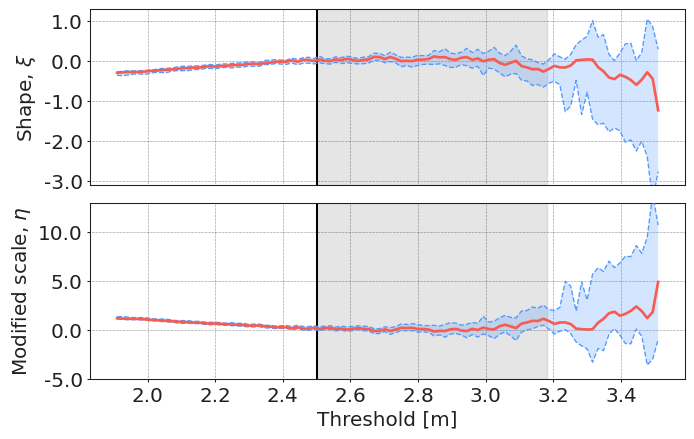

In [30]:
ax = pe.plot_parameter_stability(tg_vlis.SL.dropna(), alpha=0.95, progress=True)
ax[0].fill_between([2.5, 3.18], -3.1, 1.3, color="grey", alpha=0.2)
ax[0].set_ylim(-3.1, 1.3)
ax[0].axvline(2.5, color="k")
ax[1].fill_between([2.5, 3.18], -5, 13, color="grey", alpha=0.2)
ax[1].set_ylim(-5, 13)
ax[1].axvline(2.5, color="k")
ax[1].set_xlabel("Threshold [m]", fontsize=15)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=15)
ax[1].set_ylabel("Modified scale, $\eta$", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)
plt.show()

calculating stability parameters: 100%|██████████| 100/100 [05:03<00:00,  3.04s/it]
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3891918422.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3891918422.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3891918422.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)


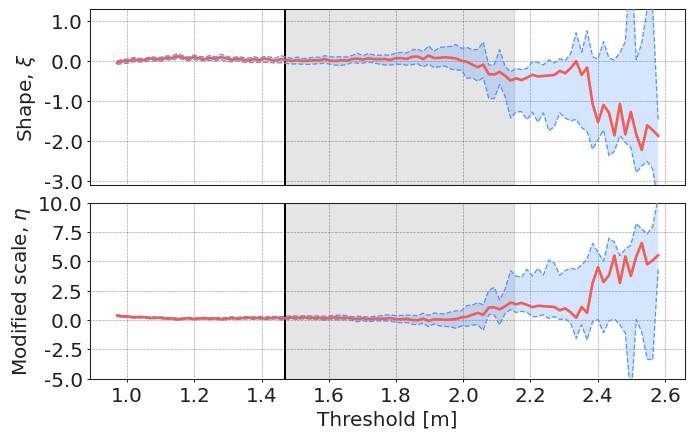

In [31]:
ax = pe.plot_parameter_stability(tg_schev.SL.dropna(), alpha=0.95, progress=True)
ax[0].fill_between([1.47, 2.15], -3.1, 1.3, color="grey", alpha=0.2)
ax[0].set_ylim(-3.1, 1.3)
ax[0].axvline(1.47, color="k")
ax[1].fill_between([1.47, 2.15], -5, 10, color="grey", alpha=0.2)
ax[1].set_ylim(-5, 10)
ax[1].axvline(1.47, color="k")
ax[1].set_xlabel("Threshold [m]", fontsize=15)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=15)
ax[1].set_ylabel("Modified scale, $\eta$", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)
plt.show()

calculating stability parameters: 100%|██████████| 100/100 [05:54<00:00,  3.54s/it]
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3397580153.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3397580153.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
C:\Users\schijven\AppData\Local\Temp\ipykernel_8536\3397580153.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)


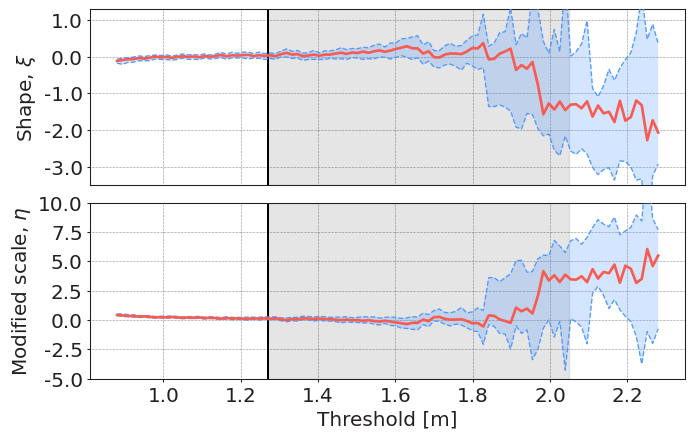

In [32]:
ax = pe.plot_parameter_stability(tg_eur.SL.dropna(), alpha=0.95, progress=True)
ax[0].fill_between([1.27, 2.05], -3.5, 1.3, color="grey", alpha=0.2)
ax[0].set_ylim(-3.5, 1.3)
ax[0].axvline(1.27, color="k")
ax[1].fill_between([1.27, 2.05], -5, 10, color="grey", alpha=0.2)
ax[1].set_ylim(-5, 10)
ax[1].axvline(1.27, color="k")
ax[1].set_xlabel("Threshold [m]", fontsize=15)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=15)
ax[1].set_ylabel("Modified scale, $\eta$", fontsize=15)
ax[1].set_xticklabels(ax[1].get_xticks().round(2), fontsize=15)
ax[0].set_yticklabels(ax[0].get_yticks(), fontsize=15)
ax[1].set_yticklabels(ax[1].get_yticks(), fontsize=15)
plt.show()

## Extreme value analysis plots

C:\Users\schijven\AppData\Local\anaconda3\envs\Modelthesis\Lib\site-packages\pyextremes\extremes\peaks_over_threshold.py:94: RuntimeWarning: invalid value encountered in greater
  exceedances = ts.loc[ts.values > threshold]
C:\Users\schijven\AppData\Local\anaconda3\envs\Modelthesis\Lib\site-packages\pyextremes\plotting\extremes.py:176: RuntimeWarning: invalid value encountered in greater
  exceedances = ts.loc[ts.values > threshold]


69


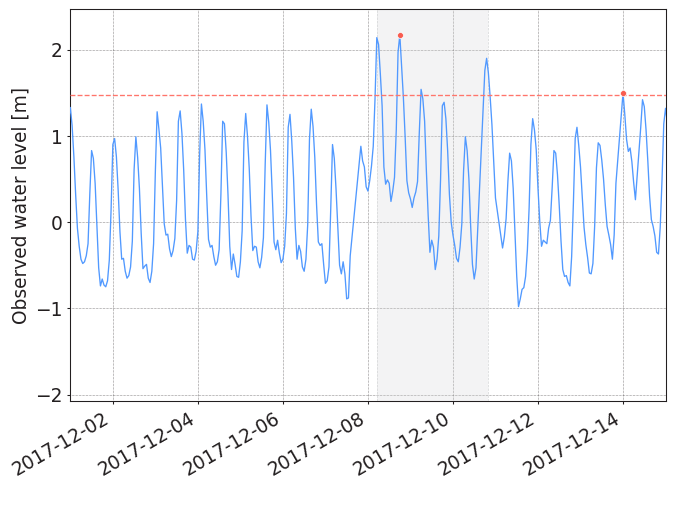

In [46]:
extremes_schev = pe.get_extremes(ytrue_schev+tidesy_schev, "POT", threshold=1.47, r="48H")
print(len(extremes_schev))
extremes_schev_dcsm = pe.get_extremes(dcsm_schev.TG+dcsm_schev.tides, "POT", threshold=1.47, r="48H")

pe.plotting.plot_extremes(
    ts=ytrue_schev+tidesy_schev,
    extremes=extremes_schev,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.47,
    figsize=(8,6),
    r="48H"
)
# plt.xlim(ytrue_schev.index[0], ytrue_schev.index[-1])
ticks = np.arange(ytrue_schev.index[0], ytrue_schev.index[-1]+timedelta(days=120), dtype='datetime64[2D]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=14)
# plt.xlim(ytrue_schev.index[0], ytrue_schev.index[-1])
# plt.xlim(datetime(2015, 10, 1), datetime(2016, 4, 1))
plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
plt.ylabel("Observed water level [m]", fontsize=14)
plt.xlabel(" ", fontsize=14)
plt.yticks(fontsize=14)
plt.gca().lines[0].set_linewidth(1)
plt.grid()

(68,)


Text(0.5, 0, 'Date')

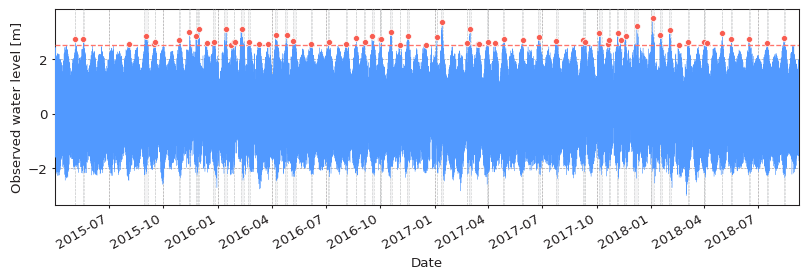

In [34]:
extremes_vlis = pe.get_extremes(ytrue_vlis+tidesy_vlis, "POT", threshold=2.5, r="48h")
print(extremes_vlis.shape)
extremes_vlis_dcsm = pe.get_extremes(dcsm_vlis.TG+dcsm_vlis.tides, "POT", threshold=2.5, r="48h")

pe.plotting.plot_extremes(
    ts=ytrue_vlis+tidesy_vlis,
    extremes=extremes_vlis,
    extremes_method="POT",
    extremes_type="high",
    threshold=2.5,
    figsize=(10,3),
    r="48H",
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_vlis.index[0], ytrue_vlis.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_vlis.index[0], ytrue_vlis.index[-1])
plt.grid()
plt.yticks(fontsize=10)
plt.ylabel("Observed water level [m]", fontsize=10)
plt.xlabel("Date", fontsize=10)

C:\Users\schijven\AppData\Local\anaconda3\envs\Modelthesis\Lib\site-packages\pyextremes\extremes\peaks_over_threshold.py:94: RuntimeWarning: invalid value encountered in greater
  exceedances = ts.loc[ts.values > threshold]
C:\Users\schijven\AppData\Local\anaconda3\envs\Modelthesis\Lib\site-packages\pyextremes\plotting\extremes.py:176: RuntimeWarning: invalid value encountered in greater
  exceedances = ts.loc[ts.values > threshold]


(70,)


Text(0, 0.5, 'Observed water level [m]')

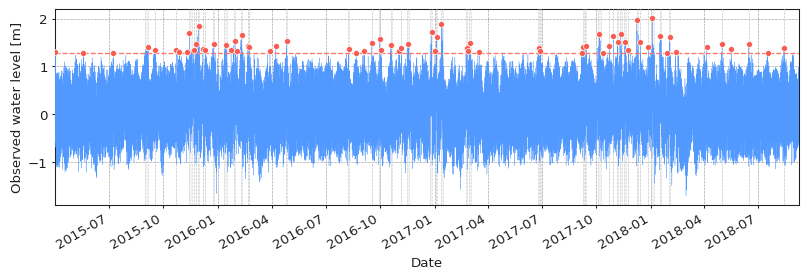

In [35]:
extremes_eur = pe.get_extremes(ytrue_eur+tidesy_eur, "POT", threshold=1.27, r="48h")
print(extremes_eur.shape)
extremes_eur_dcsm = pe.get_extremes(dcsm_eur.TG+dcsm_eur.tides, "POT", threshold=1.27, r="48h")

pe.plotting.plot_extremes(
    ts=ytrue_eur+tidesy_eur,
    extremes=extremes_eur,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.27,
    figsize=(10,3),
    r="48H",
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_eur.index[0], ytrue_eur.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_eur.index[0], ytrue_eur.index[-1])
plt.grid()
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylabel("Observed water level [m]", fontsize=10)

## EVA metrics

In [36]:
# plt.figure(figsize=(10,5))
# plt.scatter(extremes_schev.index, extremes_schev, label="TG")
# plt.scatter(ypred_schev.loc[extremes_schev.index].index, ypred_schev.loc[extremes_schev.index]+tidesy_schev.loc[extremes_schev.index], label="ML")
# plt.scatter(dcsm_schev.loc[extremes_schev_dcsm.index].index, dcsm_schev.loc[extremes_schev_dcsm.index].waterlevel, label="DCSM")
# plt.grid()
# plt.legend()
# plt.ylabel("Water level [m]")
# plt.xlabel("Time")
# ticks = np.arange(extremes_schev.index[0], extremes_schev.index[-1]+timedelta(days=65), dtype='datetime64[2M]')
# plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right")
# plt.show()

In [37]:
# Performance high water levels

yte_vlis = extremes_vlis.values
ype_vlis = ypred_vlis.loc[extremes_vlis.index].values + tidesy_vlis.loc[extremes_vlis.index].values

yte_schev = extremes_schev.values
ype_schev = ypred_schev.loc[extremes_schev.index].values + tidesy_schev.loc[extremes_schev.index].values

yte_eur = extremes_eur.values
ype_eur = ypred_eur.loc[extremes_eur.index].values + tidesy_eur.loc[extremes_eur.index].values

# For Vlissingen
mse_vlis = mean_squared_error(yte_vlis, ype_vlis)
# snr_vlis = snr(yt_vlis, yp_vlis)
s = np.var(yt_vlis)
n = np.var(yte_vlis - ype_vlis)
snr_vlis = s/n
mae_vlis = mean_absolute_error(yte_vlis, ype_vlis)
std_vlis = np.std(yte_vlis - ype_vlis)

# For Scheveningen
mse_schev = mean_squared_error(yte_schev, ype_schev)
# snr_schev = snr(yt_schev, yp_schev)
s = np.var(yt_schev)
n = np.var(yte_schev - ype_schev)
snr_schev = s/n
mae_schev = mean_absolute_error(yte_schev, ype_schev)
std_schev = np.std(yte_schev - ype_schev)

# For Europlatform
mse_eur = mean_squared_error(yte_eur, ype_eur)
# snr_eur = snr(yt_eur, yp_eur)
s = np.var(yt_eur)
n = np.var(yte_eur - ype_eur)
snr_eur = s/n
mae_eur = mean_absolute_error(yte_eur, ype_eur)
std_eur = np.std(yte_eur - ype_eur)

mse = [mse_schev.round(3), mse_vlis.round(3), mse_eur.round(3)]
snre = [snr_schev.round(1), snr_vlis.round(1), snr_eur.round(1)]
# pcc = [pcc_schev[0].round(3), pcc_vlis[0].round(3), pcc_eur[0].round(3)]
# pcc_p = [pcc_schev[1].round(3), pcc_vlis[1].round(3), pcc_eur[1].round(3)]
# print("p value of PCC is:", pcc_p)
mae = [mae_schev.round(3), mae_vlis.round(3), mae_eur.round(3)]
stde = [std_schev.round(3), std_vlis.round(3), std_eur.round(3)]

# Sample datasets and metric values
datasets = ["Scheveningen", "Vlissingen", "Europlatform"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="latex") # "presta" for inline table representation

# Print the table
print(table)

\begin{tabular}{lrrrr}
\hline
 Dataset      &   MSE &   SNR &   MAE &   Standard error \\
\hline
 Scheveningen & 0.054 &  15.3 & 0.184 &            0.164 \\
 Vlissingen   & 0.016 & 133.8 & 0.099 &            0.117 \\
 Europlatform & 0.013 &  29   & 0.09  &            0.113 \\
\hline
\end{tabular}


In [38]:
# Performance DCSM

dcsme_true_schev = extremes_schev_dcsm
dcsme_pred_schev = dcsm_schev.loc[extremes_schev_dcsm.index].waterlevel.values

dcsme_true_vlis = extremes_vlis_dcsm
dcsme_pred_vlis = dcsm_vlis.loc[extremes_vlis_dcsm.index].waterlevel.values

dcsme_true_eur = extremes_eur_dcsm
dcsme_pred_eur = dcsm_eur.loc[extremes_eur_dcsm.index].waterlevel.values

# For Vlissingen
mse_vlis = mean_squared_error(dcsme_true_vlis, dcsme_pred_vlis)
# pcc_vlis = pearsonr(dcsme_true_vlis, dcsme_pred_vlis)
s = np.var(dcsm_true_vlis)
n = np.var(dcsme_true_vlis - dcsme_pred_vlis)
snr_vlis = s/n
mae_vlis = mean_absolute_error(dcsme_true_vlis, dcsme_pred_vlis)
std_vlis = np.std(dcsme_true_vlis - dcsme_pred_vlis)

# For Scheveningen
mse_schev = mean_squared_error(dcsme_true_schev, dcsme_pred_schev)
# pcc_schev = pearsonr(dcsme_true_schev, dcsme_pred_schev)
s = np.var(dcsm_true_schev)
n = np.var(dcsme_true_schev - dcsme_pred_schev)
snr_schev = s/n
mae_schev = mean_absolute_error(dcsme_true_schev, dcsme_pred_schev)
std_schev = np.std(dcsme_true_schev - dcsme_pred_schev)

# For Europlatform
mse_eur = mean_squared_error(dcsme_true_eur, dcsme_pred_eur)
# pcc_eur = pearsonr(dcsme_true_eur, dcsme_pred_eur)
s = np.var(dcsm_true_eur)
n = np.var(dcsme_true_eur - dcsme_pred_eur)
snr_eur = s/n
mae_eur = mean_absolute_error(dcsme_true_eur, dcsme_pred_eur)
std_eur = np.std(dcsme_true_eur - dcsme_pred_eur)

mse = [mse_schev.round(3), mse_vlis.round(3), mse_eur.round(3)]
snre = [snr_schev.round(1), snr_vlis.round(1), snr_eur.round(1)]
# pcc = [pcc_schev[0].round(3), pcc_vlis[0].round(3), pcc_eur[0].round(3)]
# pcc_p = [pcc_schev[1].round(3), pcc_vlis[1].round(3), pcc_eur[1].round(3)]
# print("p value of PCC is:", pcc_p)
mae = [mae_schev.round(3), mae_vlis.round(3), mae_eur.round(3)]
stde = [std_schev.round(3), std_vlis.round(3), std_eur.round(3)]

# Sample datasets and metric values
datasets = ["Scheveningen", "Vlissingen", "Europlatform"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="latex")

# Print the table
print(table)

\begin{tabular}{lrrrr}
\hline
 Dataset      &   MSE &   SNR &   MAE &   Standard error \\
\hline
 Scheveningen & 0.019 &  42.3 & 0.103 &            0.098 \\
 Vlissingen   & 0.013 & 397.6 & 0.099 &            0.068 \\
 Europlatform & 0.006 & 141.3 & 0.066 &            0.051 \\
\hline
\end{tabular}


In [39]:
x_vlis = np.array(yp_vlis, dtype="float")
y_vlis = np.array(yt_vlis, dtype="float")
res_vlis = stats.linregress(x_vlis, y_vlis)

x_schev = np.array(yp_schev, dtype="float")
y_schev = np.array(yt_schev, dtype="float")
res_schev = stats.linregress(x_schev, y_schev)

x_eur = np.array(yp_eur, dtype="float")
y_eur = np.array(yt_eur, dtype="float")
res_eur = stats.linregress(x_eur, y_eur)

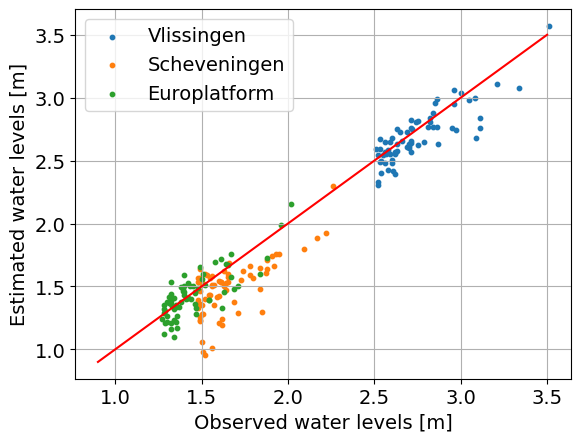

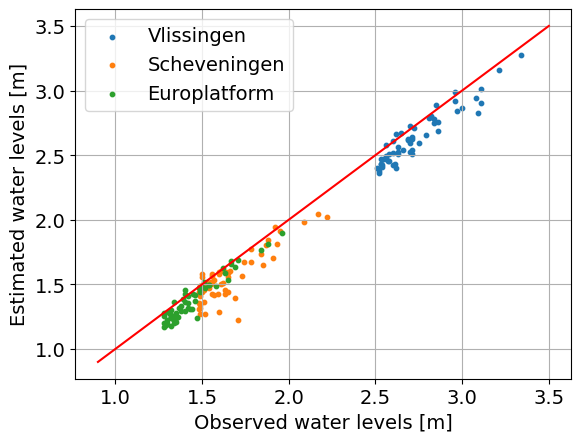

In [40]:
s = 10

plt.plot([0.9, 3.5],[0.9, 3.5],color="red")
plt.scatter(yte_vlis, ype_vlis, s=s, label="Vlissingen")
# plt.plot([x_vlis.min(), x_vlis.max()], [res_vlis.intercept + res_vlis.slope*x_vlis.min(), res_vlis.intercept + res_vlis.slope*x_vlis.max()], color="#1f77b4", linestyle="dashed")
plt.scatter(yte_schev, ype_schev, s=s, label="Scheveningen")
# plt.plot([x_schev.min(), x_schev.max()], [res_schev.intercept + res_schev.slope*x_schev.min(), res_schev.intercept + res_schev.slope*x_schev.max()], color="#ff7f0e", linestyle="dashed")
plt.scatter(yte_eur, ype_eur, s=s, label="Europlatform")
# plt.plot([x_eur.min(), x_eur.max()], [res_eur.intercept + res_eur.slope*x_eur.min(), res_eur.intercept + res_eur.slope*x_eur.max()], color="#2ca02c", linestyle="dashed")
plt.ylabel("Estimated water levels [m]", fontsize=14)
plt.xlabel("Observed water levels [m]", fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

plt.plot([0.9, 3.5],[0.9, 3.5],color="red")
plt.scatter(dcsme_true_vlis, dcsme_pred_vlis, s=s, label="Vlissingen")
plt.scatter(dcsme_true_schev, dcsme_pred_schev, s=s, label="Scheveningen")
plt.scatter(dcsme_true_eur, dcsme_pred_eur, s=s, label="Europlatform")
plt.ylabel("Estimated water levels [m]", fontsize=14)
plt.xlabel("Observed water levels [m]", fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

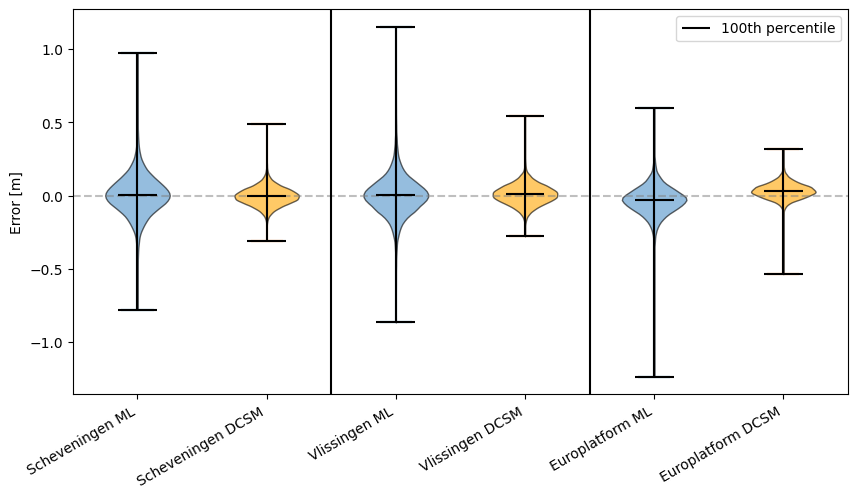

In [41]:
e_schev = yt_schev - yp_schev
e_schev_dcsm = dcsm_true_schev - dcsm_pred_schev

e_vlis = yt_vlis - yp_vlis
e_vlis_dcsm = dcsm_true_vlis - dcsm_pred_vlis

e_eur = yt_eur - yp_eur
e_eur_dcsm = dcsm_true_eur - dcsm_pred_eur

pos = [1, 2, 3, 4, 5, 6]
range_q = [0,1]
data = [np.array(e_schev).astype("float32"), np.array(e_schev_dcsm).astype("float32"), np.array(e_vlis).astype("float32"),
        np.array(e_vlis_dcsm).astype("float32"), np.array(e_eur).astype("float32"), np.array(e_eur_dcsm).astype("float32")]

plt.figure(figsize=(10, 5))
plt.axhline(0, linestyle="--", alpha=0.5, color="grey")
vp1 = plt.violinplot([data[0], data[2], data[4]], [1, 3, 5], showmeans=True, showextrema=True, quantiles=[range_q, range_q, range_q])
vp2 = plt.violinplot([data[1], data[3], data[5]], [2, 4, 6], showmeans=True, showextrema=True, quantiles=[range_q, range_q, range_q])
for pc in vp1['bodies']:
    pc.set_facecolor('#4F92C9')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
for pc in vp2['bodies']:
    pc.set_facecolor('orange')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks(pos, ["Scheveningen ML", "Scheveningen DCSM", "Vlissingen ML", "Vlissingen DCSM", "Europlatform ML", "Europlatform DCSM"], rotation=30, ha="right")
for i in range(6):
    quantiles = np.percentile(data[i], [0, 50, 100])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="k")
    plt.hlines(data[i].mean(), xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    if i < 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    elif i == 5:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k", label="100th percentile")
plt.ylabel("Error [m]")
plt.axvline(2.5, color="k")
plt.axvline(4.5, color="k")
plt.xlim(0.5, 6.5)
# plt.ylim(-1, 1.25)
plt.legend()
plt.show()

## EVA K-fold

In [42]:
extremes_1 = pe.get_extremes(ytrue_1+tidesy_1, "POT", threshold=1.47, r="48h")
extremes_2 = pe.get_extremes(ytrue_2+tidesy_2, "POT", threshold=1.47, r="48h")
extremes_3 = pe.get_extremes(ytrue_3+tidesy_3, "POT", threshold=1.47, r="48h")
extremes_4 = pe.get_extremes(ytrue_4+tidesy_4, "POT", threshold=1.47, r="48h")

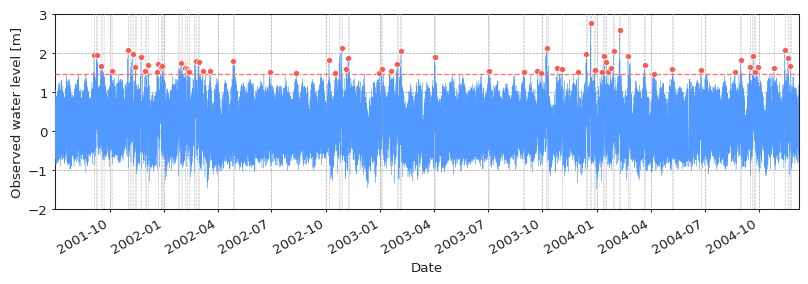

In [43]:
pe.plotting.plot_extremes(
    ts=ytrue_1+tidesy_1,
    extremes=extremes_1,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.47,
    figsize=(10,3),
    r="48H"
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_1.index[0]+timedelta(days=120), ytrue_1.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_1.index[0], ytrue_1.index[-1])
plt.ylabel("Observed water level [m]", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylim(-2, 3)
plt.grid()

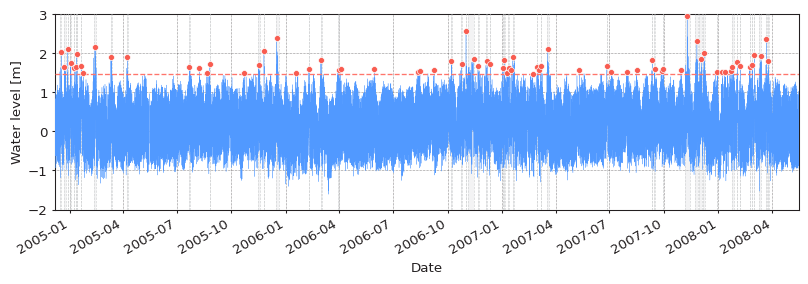

In [44]:
pe.plotting.plot_extremes(
    ts=ytrue_2+tidesy_2,
    extremes=extremes_2,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.47,
    figsize=(10,3),
    r="48H"
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_2.index[0], ytrue_2.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_2.index[0], ytrue_2.index[-1])
plt.ylabel("Water level [m]", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylim(-2, 3)
plt.grid()

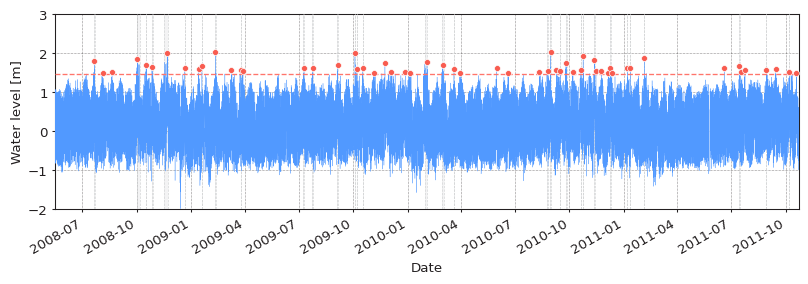

In [45]:
pe.plotting.plot_extremes(
    ts=ytrue_3+tidesy_3,
    extremes=extremes_3,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.47,
    figsize=(10,3),
    r="48H"
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_3.index[0], ytrue_3.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_3.index[0], ytrue_3.index[-1])
plt.ylabel("Water level [m]", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylim(-2, 3)
plt.grid()

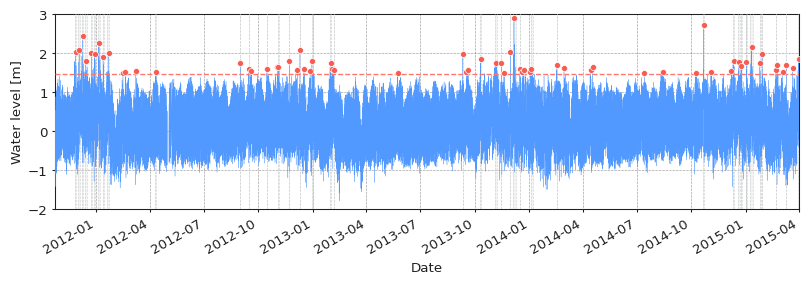

In [46]:
pe.plotting.plot_extremes(
    ts=ytrue_4+tidesy_4,
    extremes=extremes_4,
    extremes_method="POT",
    extremes_type="high",
    threshold=1.47,
    figsize=(10,3),
    r="48H"
)
# plt.xlim(datetime(2017, 12, 1), datetime(2017, 12, 15))
ticks = np.arange(ytrue_4.index[0], ytrue_4.index[-1]+timedelta(days=120), dtype='datetime64[3M]')
plt.xticks(ticks=ticks, labels=ticks, rotation=30, ha="right", fontsize=10)
plt.xlim(ytrue_4.index[0], ytrue_4.index[-1])
plt.ylabel("Water level [m]", fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Date", fontsize=10)
plt.ylim(-2, 3)
plt.grid()

In [47]:
extremes_schev.shape, extremes_1.shape, extremes_2.shape, extremes_3.shape, extremes_4.shape, extremes_eur.shape, extremes_vlis.shape

((69,), (70,), (74,), (57,), (66,), (70,), (68,))

In [48]:
# Performance  high water levels k-fold

yt_1 = extremes_1.values
yp_1 = ypred_1.loc[extremes_1.index].values + tidesy_1.loc[extremes_1.index].values

yt_2 = extremes_2.values
yp_2 = ypred_2.loc[extremes_2.index].values + tidesy_2.loc[extremes_2.index].values

yt_3 = extremes_3.values
yp_3 = ypred_3.loc[extremes_3.index].values + tidesy_3.loc[extremes_3.index].values

yt_4 = extremes_4.values
yp_4 = ypred_4.loc[extremes_4.index].values + tidesy_4.loc[extremes_4.index].values


# For validation set 1
mse_1 = mean_squared_error(yt_1, yp_1)
# pcc_1 = pearsonr(yt_1, yp_1)
s = np.var(ytrue_1 + tidesy_1)
n = np.var(yt_1 - yp_1)
snr_1 = s/n
mae_1 = mean_absolute_error(yt_1, yp_1)
std_1 = np.std(yt_1 - yp_1)

# For validation set 2
mse_2 = mean_squared_error(yt_2, yp_2)
# pcc_2 = pearsonr(yt_2, yp_2)
s = np.var(ytrue_2 + tidesy_2)
n = np.var(yt_2 - yp_2)
snr_2 = s/n
mae_2 = mean_absolute_error(yt_2, yp_2)
std_2 = np.std(yt_2 - yp_2)

# For validation set 3
mse_3 = mean_squared_error(yt_3, yp_3)
# pcc_3 = pearsonr(yt_3, yp_3)
s = np.var(ytrue_3 + tidesy_3)
n = np.var(yt_3 - yp_3)
snr_3 = s/n
mae_3 = mean_absolute_error(yt_3, yp_3)
std_3 = np.std(yt_3 - yp_3)

# For validation set 4
mse_4 = mean_squared_error(yt_4, yp_4)
# pcc_4 = pearsonr(yt_4, yp_4)
s = np.var(ytrue_4 + tidesy_4)
n = np.var(yt_4 - yp_4)
snr_4 = s/n
mae_4 = mean_absolute_error(yt_4, yp_4)
std_4 = np.std(yt_4 - yp_4)

mse = [mse_1.round(3), mse_2.round(3), mse_3.round(3), mse_4.round(3)]
snre = [snr_1.round(1), snr_2.round(1), snr_3.round(1), snr_4.round(1)]
# pcc = [pcc_1[0].round(3), pcc_2[0].round(3), pcc_3[0].round(3), pcc_4[0].round(3)]
# pcc_p = [pcc_1[1].round(3), pcc_2[1].round(3), pcc_3[1].round(3), pcc_4[1].round(3)]
# print("p value of PCC is:", pcc_p)
mae = [mae_1.round(3), mae_2.round(3), mae_3.round(3), mae_4.round(3)]
stde = [std_1.round(3), std_2.round(3), std_3.round(3), std_4.round(3)]

# Sample datasets and metric values
datasets = ["Validation set 1", "Validation set 2", "Validation set 3", "Validation set 4"]
metrics = ["MSE", "SNR", "MAE", "Standard error"]
# mse and mae in meters
datal = [mse, snre, mae, stde]
datalt = [[row[i] for row in datal] for i in range(len(datal[0]))]
# Create a list of lists for tabulation, including dataset names as the first column
table_data = [[dataset] + values for dataset, values in zip(datasets, datalt)]

# Tabulate the data
table = tabulate(table_data, headers=["Dataset"] + metrics, tablefmt="latex") # "presta" for inline table representation

# Print the table
print(table)

\begin{tabular}{lrrrr}
\hline
 Dataset          &   MSE &   SNR &   MAE &   Standard error \\
\hline
 Validation set 1 & 0.034 &  14.8 & 0.139 &            0.171 \\
 Validation set 2 & 0.044 &  13.2 & 0.148 &            0.183 \\
 Validation set 3 & 0.039 &  14.2 & 0.15  &            0.171 \\
 Validation set 4 & 0.034 &  15.6 & 0.142 &            0.166 \\
\hline
\end{tabular}


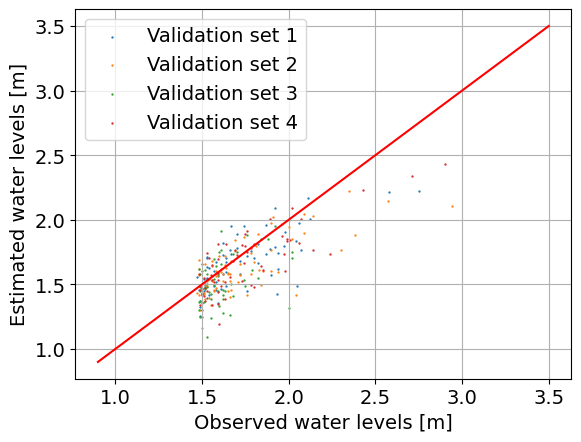

In [49]:
plt.plot([0.9, 3.5],[0.9, 3.5],color="red")
plt.scatter(yt_1, yp_1, s=s, label="Validation set 1")
# plt.plot([x_vlis.min(), x_vlis.max()], [res_vlis.intercept + res_vlis.slope*x_vlis.min(), res_vlis.intercept + res_vlis.slope*x_vlis.max()], color="#1f77b4", linestyle="dashed")
plt.scatter(yt_2, yp_2, s=s, label="Validation set 2")
# plt.plot([x_schev.min(), x_schev.max()], [res_schev.intercept + res_schev.slope*x_schev.min(), res_schev.intercept + res_schev.slope*x_schev.max()], color="#ff7f0e", linestyle="dashed")
plt.scatter(yt_3, yp_3, s=s, label="Validation set 3")
# plt.plot([x_eur.min(), x_eur.max()], [res_eur.intercept + res_eur.slope*x_eur.min(), res_eur.intercept + res_eur.slope*x_eur.max()], color="#2ca02c", linestyle="dashed")
plt.scatter(yt_4, yp_4, s=s, label="Validation set 4")
plt.ylabel("Estimated water levels [m]", fontsize=14)
plt.xlabel("Observed water levels [m]", fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

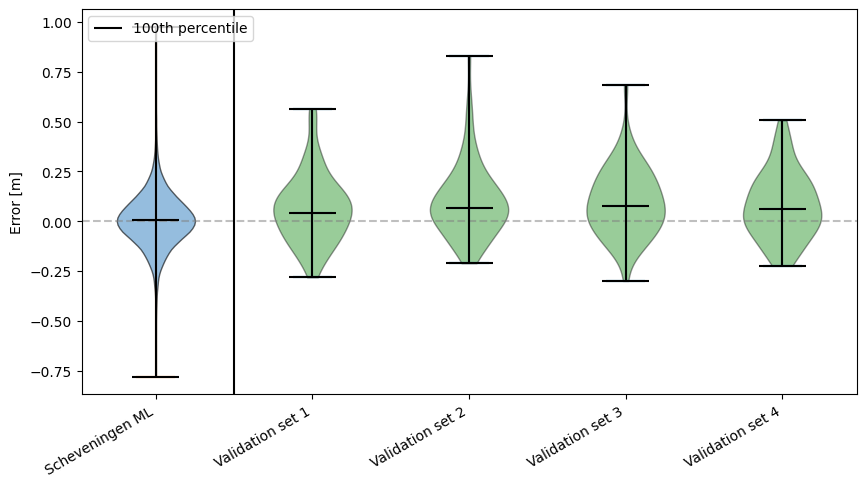

In [50]:
e1 = yt_1 - yp_1
e2 = yt_2 - yp_2
e3 = yt_3 - yp_3
e4 = yt_4 - yp_4
e0 = yt_schev - yp_schev

pos = [1, 2, 3, 4, 5]
range_q = [0,1]
data = [np.array(e0).astype("float32"), np.array(e1).astype("float32"), np.array(e2).astype("float32"),
        np.array(e3).astype("float32"), np.array(e4).astype("float32")]

plt.figure(figsize=(10, 5))
plt.axhline(0, linestyle="--", alpha=0.5, color="grey")
vp1 = plt.violinplot([data[1], data[2], data[3], data[4]], [2, 3, 4, 5], showmedians=True, showextrema=True, quantiles=[range_q, range_q, range_q, range_q])
vp2 = plt.violinplot([data[0]], [1], showmedians=True, showextrema=True, quantiles=[range_q])
for pc in vp1['bodies']:
    pc.set_facecolor('green')
    pc.set_edgecolor('k')
    pc.set_alpha(0.4)
for pc in vp2['bodies']:
    pc.set_facecolor('#4F92C9')
    pc.set_edgecolor('k')
    pc.set_alpha(0.6)
plt.xticks(pos, ["Scheveningen ML", "Validation set 1", "Validation set 2", "Validation set 3", "Validation set 4"], rotation=30, ha="right")
for i in range(5):
    quantiles = np.percentile(data[i], [0, 50, 100])
    plt.vlines(i+1, ymin=quantiles[0], ymax=quantiles[2], color="k")
    plt.hlines(quantiles[1], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    plt.hlines(quantiles[0], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    if i < 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k")
    elif i == 4:
        plt.hlines(quantiles[2], xmin=i+1-0.15, xmax=i+1+0.15, color="k", label="100th percentile")
plt.ylabel("Error [m]")
plt.axvline(1.5, color="k")
plt.legend(loc=2)
plt.show()

In [51]:
print("MSE:", (np.mean(mse)).round(3), "m +-", (np.max(mse) - np.min(mse)).round(3), "m")
print("SNR:", (np.mean(snre)).round(1), "+-", (np.max(snre) - np.min(snre)).round(1))
print("MAE:", (np.mean(mae)).round(3), "m +-", (np.max(mae) - np.min(mae)).round(3), "m")
print("Standard error:", (np.mean(stde)).round(3), "m +-", (np.max(stde) - np.min(stde)).round(3), "m")

MSE: 0.038 m +- 0.01 m
SNR: 14.4 +- 2.4
MAE: 0.145 m +- 0.011 m
Standard error: 0.173 m +- 0.017 m
